# Assessing Lake Titicaca’s water levels in support of water management

Production date: 19-08-2025

Produced by: Amaya Camila Trigoso Barrientos (VUB)

## 🌍 Use case: Utilizing satellite altimetry to support integrated water resources management in the Titicaca–Desaguadero–Poopó–Salar de Coipasa (TDPS) System

## ❓ Quality assessment question(s)
* **Is the temporal completeness of the satellite-derived lake water level dataset for Lake Titicaca sufficient to support water resources management in the Titicaca–Desaguadero–Poopó–Salar de Coipasa (TDPS) System?**

The [lake water levels from 1992 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-level?tab=overview) (C3S-LWL v5.0) dataset provides long-term water level observations for numerous lakes worldwide. The Climate Data Record (CDR) of the C3S-LWL v5.0 dataset is updated annually. The dataset provides at least 10 years of temporal coverage. However, the specific temporal coverage and average time step vary by lake (time steps are irregular). The dataset provides one value of water level per time step. Interim Climate Data Records (ICDRs) are not yet available for this dataset. 

This dataset can be useful for Integrated Water Resources Management (IWRM) applications such as understanding lake responses to seasonal dynamics, climate variability, and long-term climate change-factors which directly influence water availability for ecosystems and dependent human populations. To illustrate the potential applicability of the dataset, Lake Titicaca was selected as a case study. The lake forms part of the Titicaca–Desaguadero–Poopó–Salar de Coipasa (TDPS) hydrological system, which spans Peru and Bolivia. This system provides critical freshwater resources to millions of people, supporting agriculture, domestic use, and ecosystem services across the Altiplano. Lake Titicaca feeds the Desaguadero River, which flows into Lake Poopó. This hydrological system is complex and subject to multiple drivers (e.g., climate variability, land use change, population growth), which exert pressures on water availability and quality. These pressures affect the state of the system, such as lake levels, which in turn have impacts on ecosystems and human livelihoods [[1]](https://doi.org/10.3390/w8040144) [[2]](https://doi.org/10.1016/j.ejrh.2021.100927).

The objective of this assessment is to examine the temporal completeness of Lake Titicaca's water level data in the C3S-LWL v5.0 dataset and assess its ability to support Integrated Water Resources Management (IWRM) in the context of the TDPS system.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The temporal completeness of the C3S–LWL v5.0 dataset improves significantly after 2016, following the deployment of Sentinel-3A and Jason-3, and is further enhanced by the launches of Sentinel-3B (2018) and Sentinel-6A (2020).

* For Lake Titicaca, the dataset is sufficiently complete to capture seasonal water level patterns and major hydrological extremes (floods and droughts), supporting general analysis and long-term IWRM applications. 

* The current temporal span and gaps in the dataset limit its ability to reliably detect and analyze ENSO-related effects on Titicaca lake's water levels.

```

## 📋 Methodology

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-1)**
 * Download all available C3S–LWL v5.0 satellite-lake-water-level data for Lake Titicaca.

**[](section-2)**
 * Calculate performance indicators related to temporal resolution: median timestep and max. timestep for different periods of time.
 * Plot the number of water level records per month across the dataset’s full temporal span.
 * Analyze the causes of data gaps and changes in data availability over time using information from the dataset’s Documentation.

**[](section-3)**
 * Plot the time series of water levels, highlighting the upper 99% and lower 1% quantiles, and indicate seasonal patterns.
 * Evaluate whether the dataset captures seasonality and extreme events, and discuss the implications for IWRM.
 * Analyze the relationship between ENSO phases and Lake Titicaca’s water levels using an approach adapted from Gutierrez-Villarreal et al. (2024) [[5]](https://doi.org/10.1016/j.wace.2024.100710), and assess whether this relationship is evident in the C3S–LWL v5.0 dataset.

**[](section-4)**
 * Calculate the percentile ranks of Lake Titicaca across key performance indicators to assess its relative data completeness within the dataset.
 * Analyzed the suitability of the dataset for applying similar assessments to other lakes in support of IWRM.
 

## 📈 Analysis and results

(section-1)=
### 1. Request and download data

#### Import packages

In [1]:
from tabulate import tabulate
import cartopy.crs as ccrs
import fsspec
import matplotlib.cbook
import pandas as pd
import xarray as xr
import warnings
import numpy as np
import matplotlib.pyplot as plt
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
import seaborn as sns

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-notebook")

#### Set data request

In [2]:
collection_id = "satellite-lake-water-level"
request = {
    "variable": "all",
    "region": "southern_america",
    "lake": "titicaca",
}
#varname = "water_surface_height_above_reference_datum"

#### Download data

In [3]:
da_all = download.download_and_transform(collection_id, request).compute()

100%|██████████| 1/1 [00:00<00:00, 13.49it/s]


In [4]:
# Extract the DataArray for water_surface_height_above_reference_datum
da = da_all["water_surface_height_above_reference_datum"]

# Extract the DataArray for water_surface_height_uncertainty
da_u = da_all["water_surface_height_uncertainty"]

(section-2)=
### 2. Temporal resolution completeness

#### PQAR performance indicators

The Product Quality Assessment Report (PQAR) for the dataset [[3]](https://confluence.ecmwf.int/pages/viewpage.action?pageId=428248112) includes a table in Annex A presenting the performance indicators calculated for all lakes. These indicators are computed for the entire available period (1992–2023) and for the most recent 10-year period (2014–2023). The median and maximum timesteps are useful indicators for assessing temporal completeness. In this section, these indicators will be calculated for Lake Titicaca and compared with the information provided in the PQAR. The maximum timestep represents the largest gap between two observations, expressed as the maximum number of days without data.

In [5]:
# Calculate time differences
time_diff = da.time.diff(dim="time")  # Time differences remain in timedelta64[ns]
median_timestep = time_diff.median().dt.days.item()  # Convert to days
max_timestep = time_diff.max().dt.days.item()        # Convert to days
timeseries_duration = (da.time[-1] - da.time[0]).dt.days.item()  # Total duration in days

# Subset for 2014 to 2023
subset_da = da.sel(time=slice("2014-01-01", "2023-12-31"))
if subset_da.size > 0:  # Ensure subset is not empty
    subset_time_diff = subset_da.time.diff(dim="time")
    subset_median_timestep = subset_time_diff.median().dt.days.item()
    subset_max_timestep = subset_time_diff.max().dt.days.item()
    subset_timeseries_duration = (subset_da.time[-1] - subset_da.time[0]).dt.days.item()
else:
    subset_median_timestep = None
    subset_max_timestep = None
    subset_timeseries_duration = None

# Print results
print("All Data:")
print(f"Median Timestep (days): {median_timestep}")
print(f"Max Timestep (days): {max_timestep}")
print(f"Timeseries Duration (years): {timeseries_duration/365}")

print("\nSubset 2014-2023:")
print(f"Median Timestep (days): {subset_median_timestep}")
print(f"Max Timestep (days): {subset_max_timestep}")

All Data:
Median Timestep (days): 28
Max Timestep (days): 142
Timeseries Duration (years): 28.5972602739726

Subset 2014-2023:
Median Timestep (days): 14
Max Timestep (days): 93


The integer part of the results are the same as the ones presented in the PQAR. 

#### Records per month

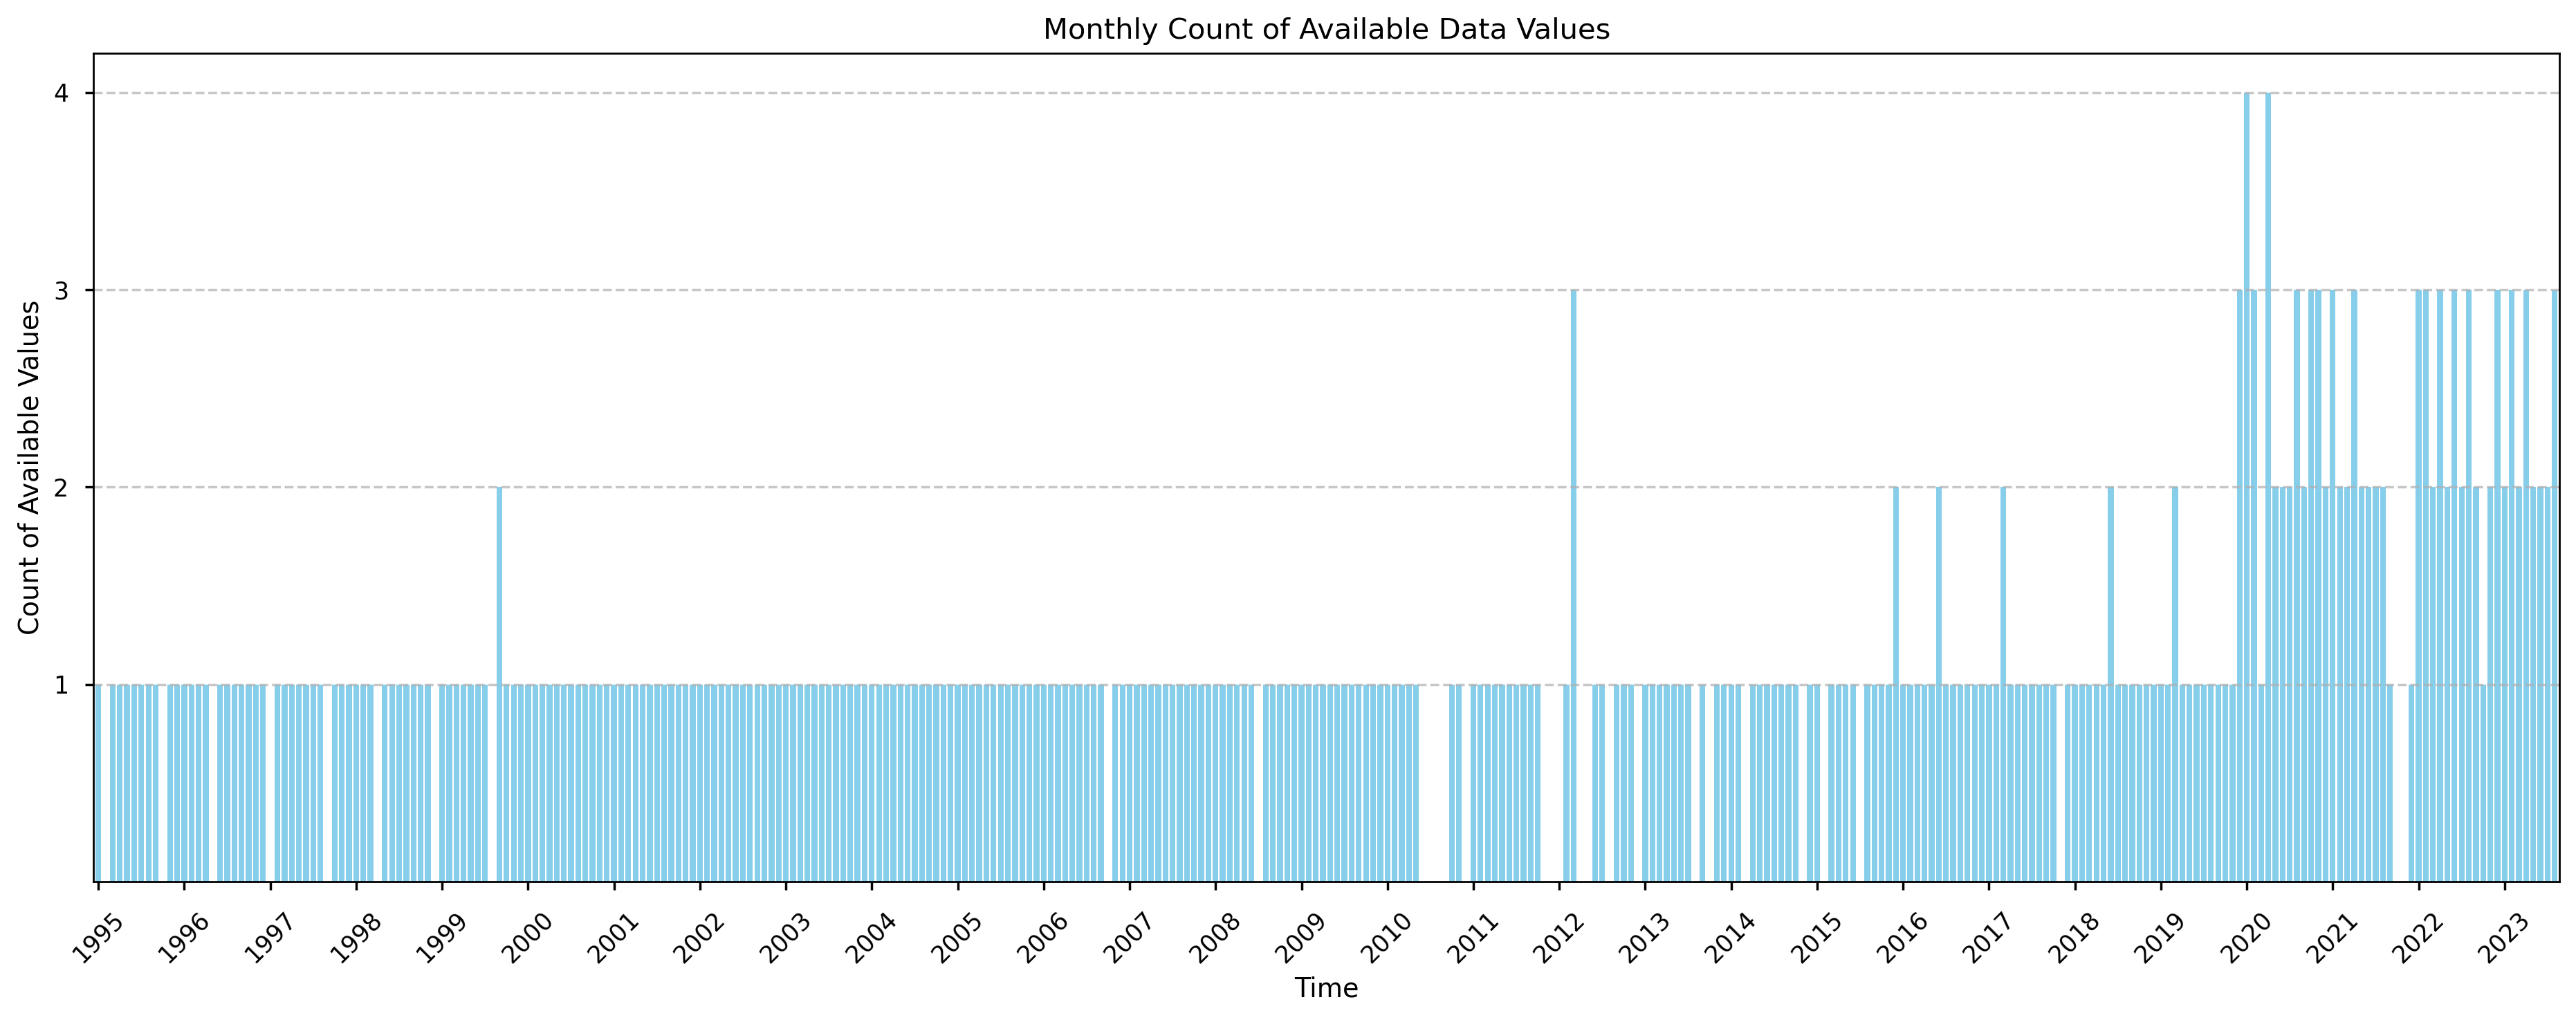

In [6]:
# Resample to monthly frequency and count non-NaN values
monthly_counts = da.resample(time="M").count()

# Convert to Pandas for easier plotting
monthly_counts_pd = monthly_counts.to_pandas()

# Plot as bars
plt.figure(figsize=(15, 6), dpi=250)
monthly_counts_pd.plot(kind='bar', color='skyblue', width=0.8)
plt.title("Monthly Count of Available Data Values")
plt.xlabel("Time")
plt.ylabel("Count of Available Values")

# Customize the x-axis labels to show only years
xticks_positions = range(0, len(monthly_counts_pd), 12)  # Tick at the start of each year
xticks_labels = monthly_counts_pd.index[::12].strftime('%Y')  # Format as year

plt.xticks(ticks=xticks_positions, labels=xticks_labels, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks([1, 2, 3, 4])
plt.tight_layout()
plt.show()

```{figure}
---
name: fig-completeness
figwidth: 100%
---
Count of values available in the CDS water level dataset per month over time.
```

A clear increase values recorded per month can be observed from 2020 onwards. Therefore, the median and maximum timestep indicators were calculated again for two periods: 1995-2019 and 2020-2023.

In [7]:
# Calculate time differences
time_diff = da.time.diff(dim="time")  # Time differences remain in timedelta64[ns]
median_timestep = time_diff.median().dt.days.item()  # Convert to days
max_timestep = time_diff.max().dt.days.item()        # Convert to days
timeseries_duration = (da.time[-1] - da.time[0]).dt.days.item()  # Total duration in days

# Subset for 1995 to 2019
subset_da = da.sel(time=slice("1995-01-01", "2019-12-31"))
if subset_da.size > 0:  # Ensure subset is not empty
    subset_time_diff = subset_da.time.diff(dim="time")
    subset_median_timestep = subset_time_diff.median().dt.days.item()
    subset_max_timestep = subset_time_diff.max().dt.days.item()
    subset_timeseries_duration = (subset_da.time[-1] - subset_da.time[0]).dt.days.item()
else:
    subset_median_timestep = None
    subset_max_timestep = None
    subset_timeseries_duration = None
# Print results
print("\nSubset 1995-2019:")
print(f"Median Timestep (days): {subset_median_timestep}")
print(f"Max Timestep (days): {subset_max_timestep}")

# Subset for 2020 to 2023
subset_da = da.sel(time=slice("2020-01-01", "2023-12-31"))
if subset_da.size > 0:  # Ensure subset is not empty
    subset_time_diff = subset_da.time.diff(dim="time")
    subset_median_timestep = subset_time_diff.median().dt.days.item()
    subset_max_timestep = subset_time_diff.max().dt.days.item()
    subset_timeseries_duration = (subset_da.time[-1] - subset_da.time[0]).dt.days.item()
else:
    subset_median_timestep = None
    subset_max_timestep = None
    subset_timeseries_duration = None

print("\nSubset 2020-2023:")
print(f"Median Timestep (days): {subset_median_timestep}")
print(f"Max Timestep (days): {subset_max_timestep}")


Subset 1995-2019:
Median Timestep (days): 31
Max Timestep (days): 142

Subset 2020-2023:
Median Timestep (days): 12
Max Timestep (days): 93


The results show that for Lake Titicaca, from 1995 to 2019, there is approximately one measurement per month (median time step of 31 days). From 2020 onwards, the number of measurements per month increases to a median time step of 12 days.

#### Satellite missions over time

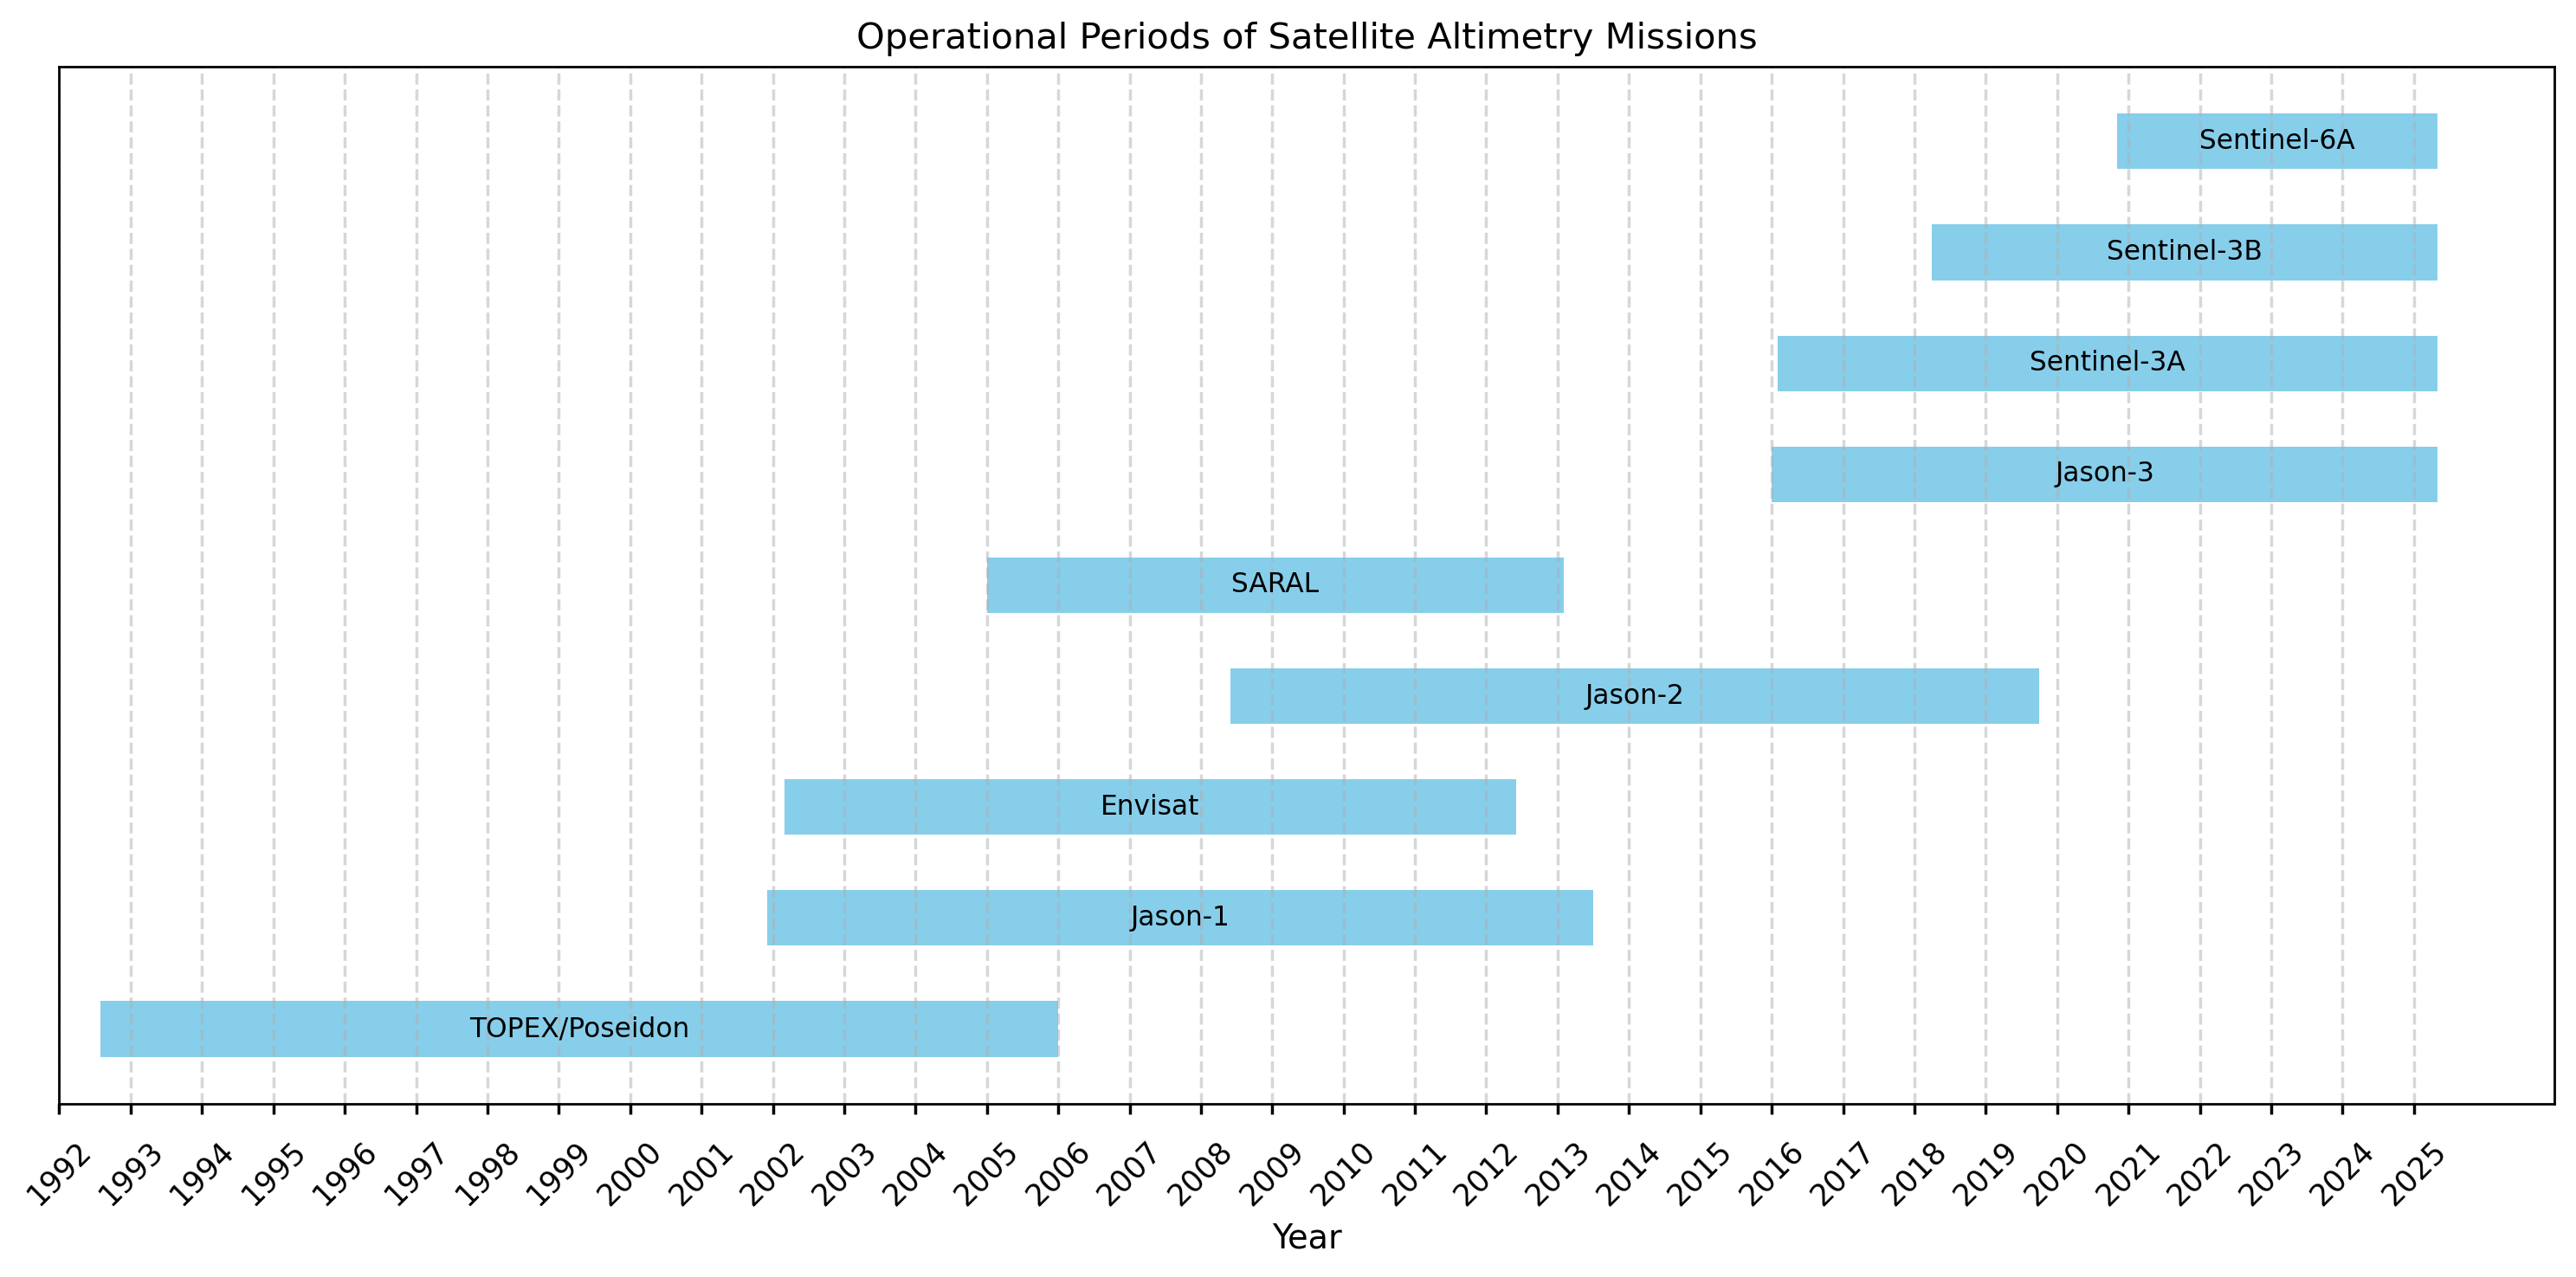

In [8]:
# Define the satellite missions and their operational periods
missions = {
    "TOPEX/Poseidon": ("1992-08", "2006-01"),
    "Jason-1": ("2001-12", "2013-07"),
    "Envisat": ("2002-03", "2012-06"),
    "Jason-2": ("2008-06", "2019-10"),
    "SARAL": ("2013-02", "2005"),
    "Jason-3": ("2016-01", "2025-05"),  # Adjust end date as needed
    "Sentinel-3A": ("2016-02", "2025-05"),  # Adjust end date as needed
    "Sentinel-3B": ("2018-04", "2025-05"),  # Adjust end date as needed
    "Sentinel-6A": ("2020-11", "2025-05"),  # Adjust end date as needed
}

# Convert the mission data into a DataFrame
df = pd.DataFrame([
    {"Mission": mission, "Start": pd.to_datetime(start), "End": pd.to_datetime(end)}
    for mission, (start, end) in missions.items()
])

# Sort the DataFrame by start date
df = df.sort_values(by="Start").reset_index(drop=True)

# Calculate durations in days
df["Duration"] = (df["End"] - df["Start"]).dt.days

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))
fig.set_dpi(250)
# Plot the bars (same as before)
for idx, row in df.iterrows():
    ax.barh(idx, row["Duration"], left=row["Start"], height=0.5, color='skyblue')
    ax.text(row["Start"] + pd.Timedelta(days=row["Duration"] / 2),
            idx,
            row["Mission"],
            va='center', ha='center', fontsize=9)

# Create a range of years for ticks
start_year = df["Start"].dt.year.min()
end_year = df["End"].dt.year.max()
years = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-01-01', freq='YS')

# Set x-axis ticks to January of each year
ax.set_xticks(years)
ax.set_xticklabels([date.strftime('%Y') for date in years], rotation=45)

# Enable grid for x-axis
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Axis labels and title
ax.set_xlabel("Year")
ax.set_title("Operational Periods of Satellite Altimetry Missions")
ax.set_yticks([])  # Optional: Hide y-ticks if labels are in bars

plt.tight_layout()
plt.show()

```{figure}
---
name: fig-missions
figwidth: 100%
---
Span of the satellite missions used to estimate water levels in the C3S–LWL v5.0 dataset. The time periods reflect the operational availability of each mission as described in the Algorithm Theoretical Basis Document (ATBD) [[4]](https://confluence.ecmwf.int/pages/viewpage.action?pageId=425328942). A correction was applied to the end year of the TOPEX/Poseidon mission to reflect its actual data availability.
```

According to the PQAR, the median time step in the lake water level dataset decreases after 2016, indicating an increase in the number of recorded values. This improvement is attributed to the introduction of Sentinel-3A and Jason-3 missions, which provided more frequent overpasses with higher-quality sensors [[3]](https://confluence.ecmwf.int/pages/viewpage.action?pageId=428248112).

For Lake Titicaca, this enhancement is evident post-2016, as months with two records became more common. Following the launch of Sentinel-3B and Sentinel-6A, a further increase in data frequency was observed, with most months after late 2019 containing two records, and some months even having three or four (see {numref}`fig-completeness`). This indicates a significant improvement in dataset completeness due to these newer missions.

Prior to 2016, the dataset exhibits more gaps, with several months lacking data. This can be explained by the limitations of earlier missions: TOPEX/Poseidon, Jason-1, Envisat, Jason-2, and SARAL. These missions had less precise instruments, making their measurements more susceptible to filtering. Although satellite coverage and sensor quality improved after 2016, a few gaps—such as those seen in 2021—may still occur. As outlined in the Algorithm Theoretical Basis Document (ATBD), data filtering is based on three criteria: (i) measurements with invalid (NaN) geophysical corrections, (ii) the backscatter coefficient (sigma0), used to eliminate measurements over land, and (iii) water-level changes exceeding D<sub>max</sub>, a lake-specific threshold defined by experts to remove unrealistically rapid variations [[4]](https://confluence.ecmwf.int/pages/viewpage.action?pageId=425328942).

(section-3)=
### 3. IWRM applications

Due to the irregular time steps, annual update frequency, and current absence of ICDRs, the C3S–LWL v5.0 dataset is not well-suited for applications requiring high temporal resolution or real-time monitoring, such as flood early warning systems or rapid drought response mechanisms. However, its long temporal span makes it valuable for applications that benefit from historical context and trend analysis. This includes assessing interannual variability, long-term climate influences, and understanding hydrological responses to large-scale drivers such as ENSO.

#### Detect seasonality and extreme events

Next, plot a time series of lake Titicaca water levels, highlighting the 1st and 99th percentiles, and marking values from April and December to explore seasonal patterns and extremes.

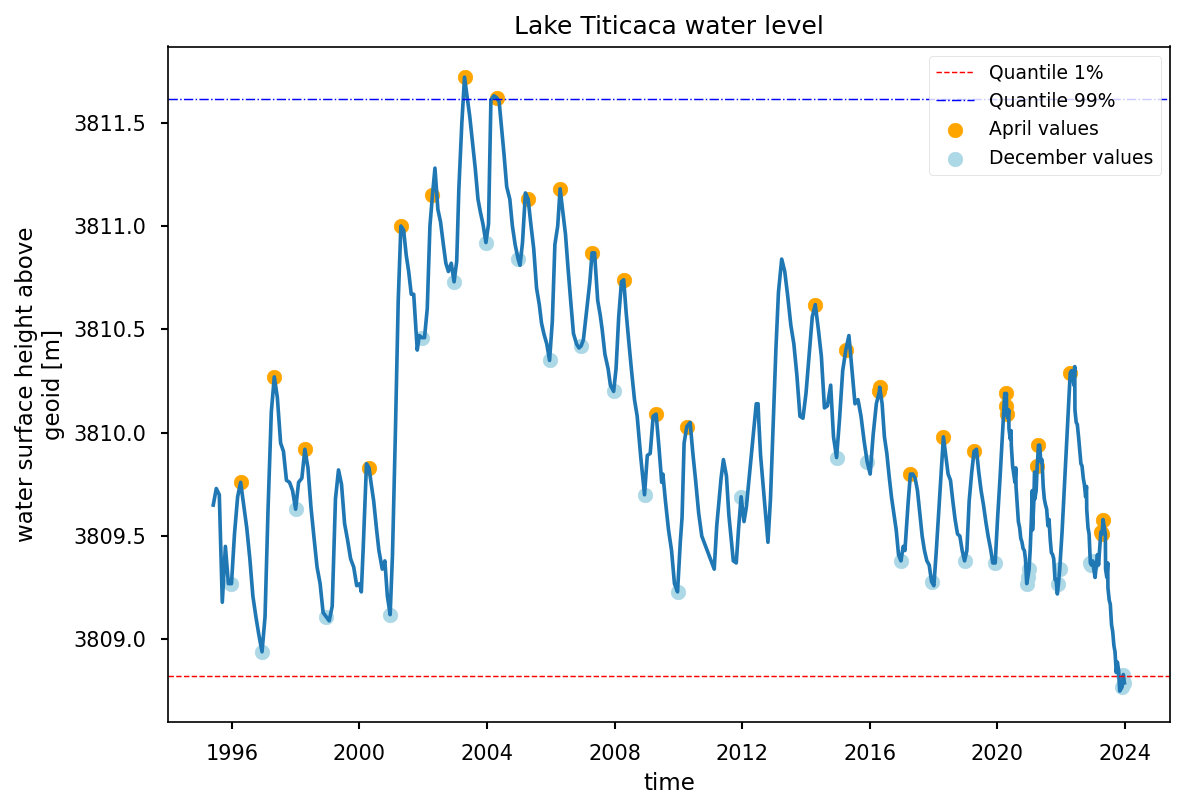

In [9]:
# Compute quantiles
da_qiles = da.quantile([0.01, 0.99])

# Extract April and December data
april_values = da.sel(time=da.time.dt.month == 4)
december_values = da.sel(time=da.time.dt.month == 12)

# Convert DataArray time coordinate to a pandas datetime index
time_index = pd.to_datetime(da['time'].values)

# Plot time series
fig, ax = plt.subplots()
fig.set_dpi(150)  # Set the display DPI for the figure
da.plot(ax=ax)

# Add quantile lines with consistent color but different line styles
quantile_styles = ["--", "-."]
colors_styles = ["red", "blue"]
for qile, style, col in zip(da_qiles, quantile_styles, colors_styles):
    ax.axhline(qile, color=col, ls=style, linewidth=0.7, label=f"Quantile {qile.coords['quantile'].item():.0%}")

# Add points for April and December with subtler colors
plt.scatter(april_values.time, april_values, color="orange", label="April values")
plt.scatter(december_values.time, december_values, color="lightblue", label="December values")

# Remove duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
unique_handles_labels = dict(zip(labels, handles))  # Remove duplicates by keeping the first occurrence
ax.legend(unique_handles_labels.values(), unique_handles_labels.keys(), fontsize=9)

# Add title
plt.title(f"Lake {request['lake'].title()} water level")

plt.tight_layout()
plt.show()

```{figure}
---
name: fig-timeseries
figwidth: 75%
---
Water level in the Titicaca Lake in the period 1995-2023 according to the C3S–LWL v5.0.
```

- **Seasonality:** The annual cycle of rainfall over the TDPS system exhibits a marked seasonality, with a rainy season from December to March that accounts for over 75% of the annual precipitation, a dry season from May to August, and a pre-wet season from September to December [[5]](https://doi.org/10.1016/j.wace.2024.100710). Lake Titicaca's level is primarily influenced by variations in precipitation and high evaporation rates [[6]](https://doi.org/10.5194/hess-29-655-2025). Consequently, December (just before the onset of the rainy season) typically corresponds to the lake’s lowest water level in the hydrological year, while the highest level usually occurs around April, at the end of the rainy season and the start of the dry season. This seasonal pattern is evident in {numref}`fig-timeseries`, which demonstrates that the dataset effectively captures seasonality despite the presence of data gaps. This information is useful for IWRM because it supports seasonal planning for water allocation, flood control, and agricultural scheduling, not only around Lake Titicaca but throughout the interconnected TDPS system. Moreover, Lake Titicaca regulates the outflow into the Desaguadero River, which in turn affects water availability downstream in Lake Poopó. Any significant deviation in seasonal rainfall or lake level delays can cascade through the system.

- **Extreme events:** {numref}`fig-timeseries` also shows that the time series captures extreme hydrological events. The upper 99% quantile reflects intense precipitation events that occurred in 2003 and 2004, leading to the overflow of rivers feeding into Lake Titicaca. These events caused a significant rise in the lake's water level, leading to flooding in surrounding areas, as reported by Peruvian government agencies [[7]](https://www.inei.gob.pe/media/MenuRecursivo/boletines/5340.pdf) [[8]](https://portal.indeci.gob.pe/wp-content/uploads/2019/01/5_1_princ_emerg.pdf). Conversely, the lower 1% quantile highlights the severe drought experienced in 2023 in the TDPS, which led to a substantial drop in lake levels, reaching a minimum by the end of the year [[9]](https://www.copernicus.eu/fr/node/40141). This event had system-wide consequences, in Puno (Peru) and La Paz (Bolivia), up to 80% of potato and sweet potato and 90% of Andean grains were lost due to water scarcity [[5]](https://doi.org/10.1016/j.wace.2024.100710). From an IWRM perspective, capturing and understanding these extremes is critical for guiding investment in adaptive infrastructure and preparing multisectoral response strategies. It also underscores the need for transboundary coordination, as hydrological impacts in one part of the system inevitably propagate throughout the TDPS basin.

#### Relation to ENSO

In the TDPS region, El Niño events are typically associated with drier conditions, while La Niña events often bring increased rainfall, particularly during the wet season (December-March). These precipitation patterns directly influence Lake Titicaca's hydrology. El Niño years tend to reduce inflows and lower lake levels, whereas La Niña years usually promote higher inflows and rising water levels. However, the 2022-2023 drought illustrates that La Niña can also be linked to severe dry conditions, particularly during the pre-wet season (September-November). Unlike its wet-season effects, La Niña during this early period is associated with decreased precipitation, which can delay the onset of the rainy season and heighten the risk of drought. Gutierrez-Villarreal et al. (2024) explain that the 2022-23 pre-wet season was one of the driest on record, with November 2022 marking the driest month in 58 years. As a result, Lake Titicaca’s seasonal rise was significantly suppressed, its water level increased by only 0.09 meters between December and April, one of the weakest rises since 1940. Notably, the lake level even declined between December and January, a rare occurrence during a period when levels typically rise [[5]](https://doi.org/10.1016/j.wace.2024.100710).

```{figure} attachment:6d5ef281-c7e9-41b5-aaa6-7866ca71d57e.jpg
---
name: fig-gutierrez
figwidth: 100%
---
Lake Titicaca's geographical location and hydrograms. a) The Lake Titicaca, Desaguadero River, and Lake Poopó basins (TDPS system) boundary is delimited by a black line, and the lake area is represented by a black polygon. Red lines in the Andean cordillera denote altitudes of 3 000 m.a.s.l. Interannual increment of lake levels of b) April, c) February, and d) January, with respect to December. The dataset spans between 1914 and 2023. The purple horizontal lines represent the long-term (1914–2023) average of lake level differences. “n” refers to the calendar year. Selected El Niño (La Niña) years are tagged with red (blue) bars if the [El Niño 3.4 index from the HadiSST](https://psl.noaa.gov/data/timeseries/month/Nino34/) [[10]](https://doi.org/10.1029/2002jd002670). dataset is higher (lower) than 0.75 (−0.75) during at least 4 months between October n-1 and April n. (For interpretation of the references to color in this figure legend, the reader is referred to the Web version of this article.)
Reproduced from Gutierrez-Villarreal et al. (2024), licensed under CC BY 4 [[5]](https://doi.org/10.1016/j.wace.2024.100710).
```

The water levels used by Gutierrez-Villarreal et al. (2024) to make {numref}`fig-gutierrez` are monthly lake level data from 1914 to 2023, measured at the Muelle Enafer station (3,800 m a.s.l.) on the Peruvian side of Lake Titicaca, and provided by Peru’s National Meteorology and Hydrology Service (SENAMHI) [[5]](https://doi.org/10.1016/j.wace.2024.100710). The figure illustrates how water levels in Lake Titicaca can be a valuable indicator for analyzing the relationship between ENSO phases and extreme events in the TDPS system, an insight that is highly relevant for IWRM due to its implications for drought preparedness and long-term planning. A similar analysis was conducted here using the C3S–LWL v5.0 dataset, to assess whether the patterns and anomalies described in the original study can also be detected with this alternative data source.

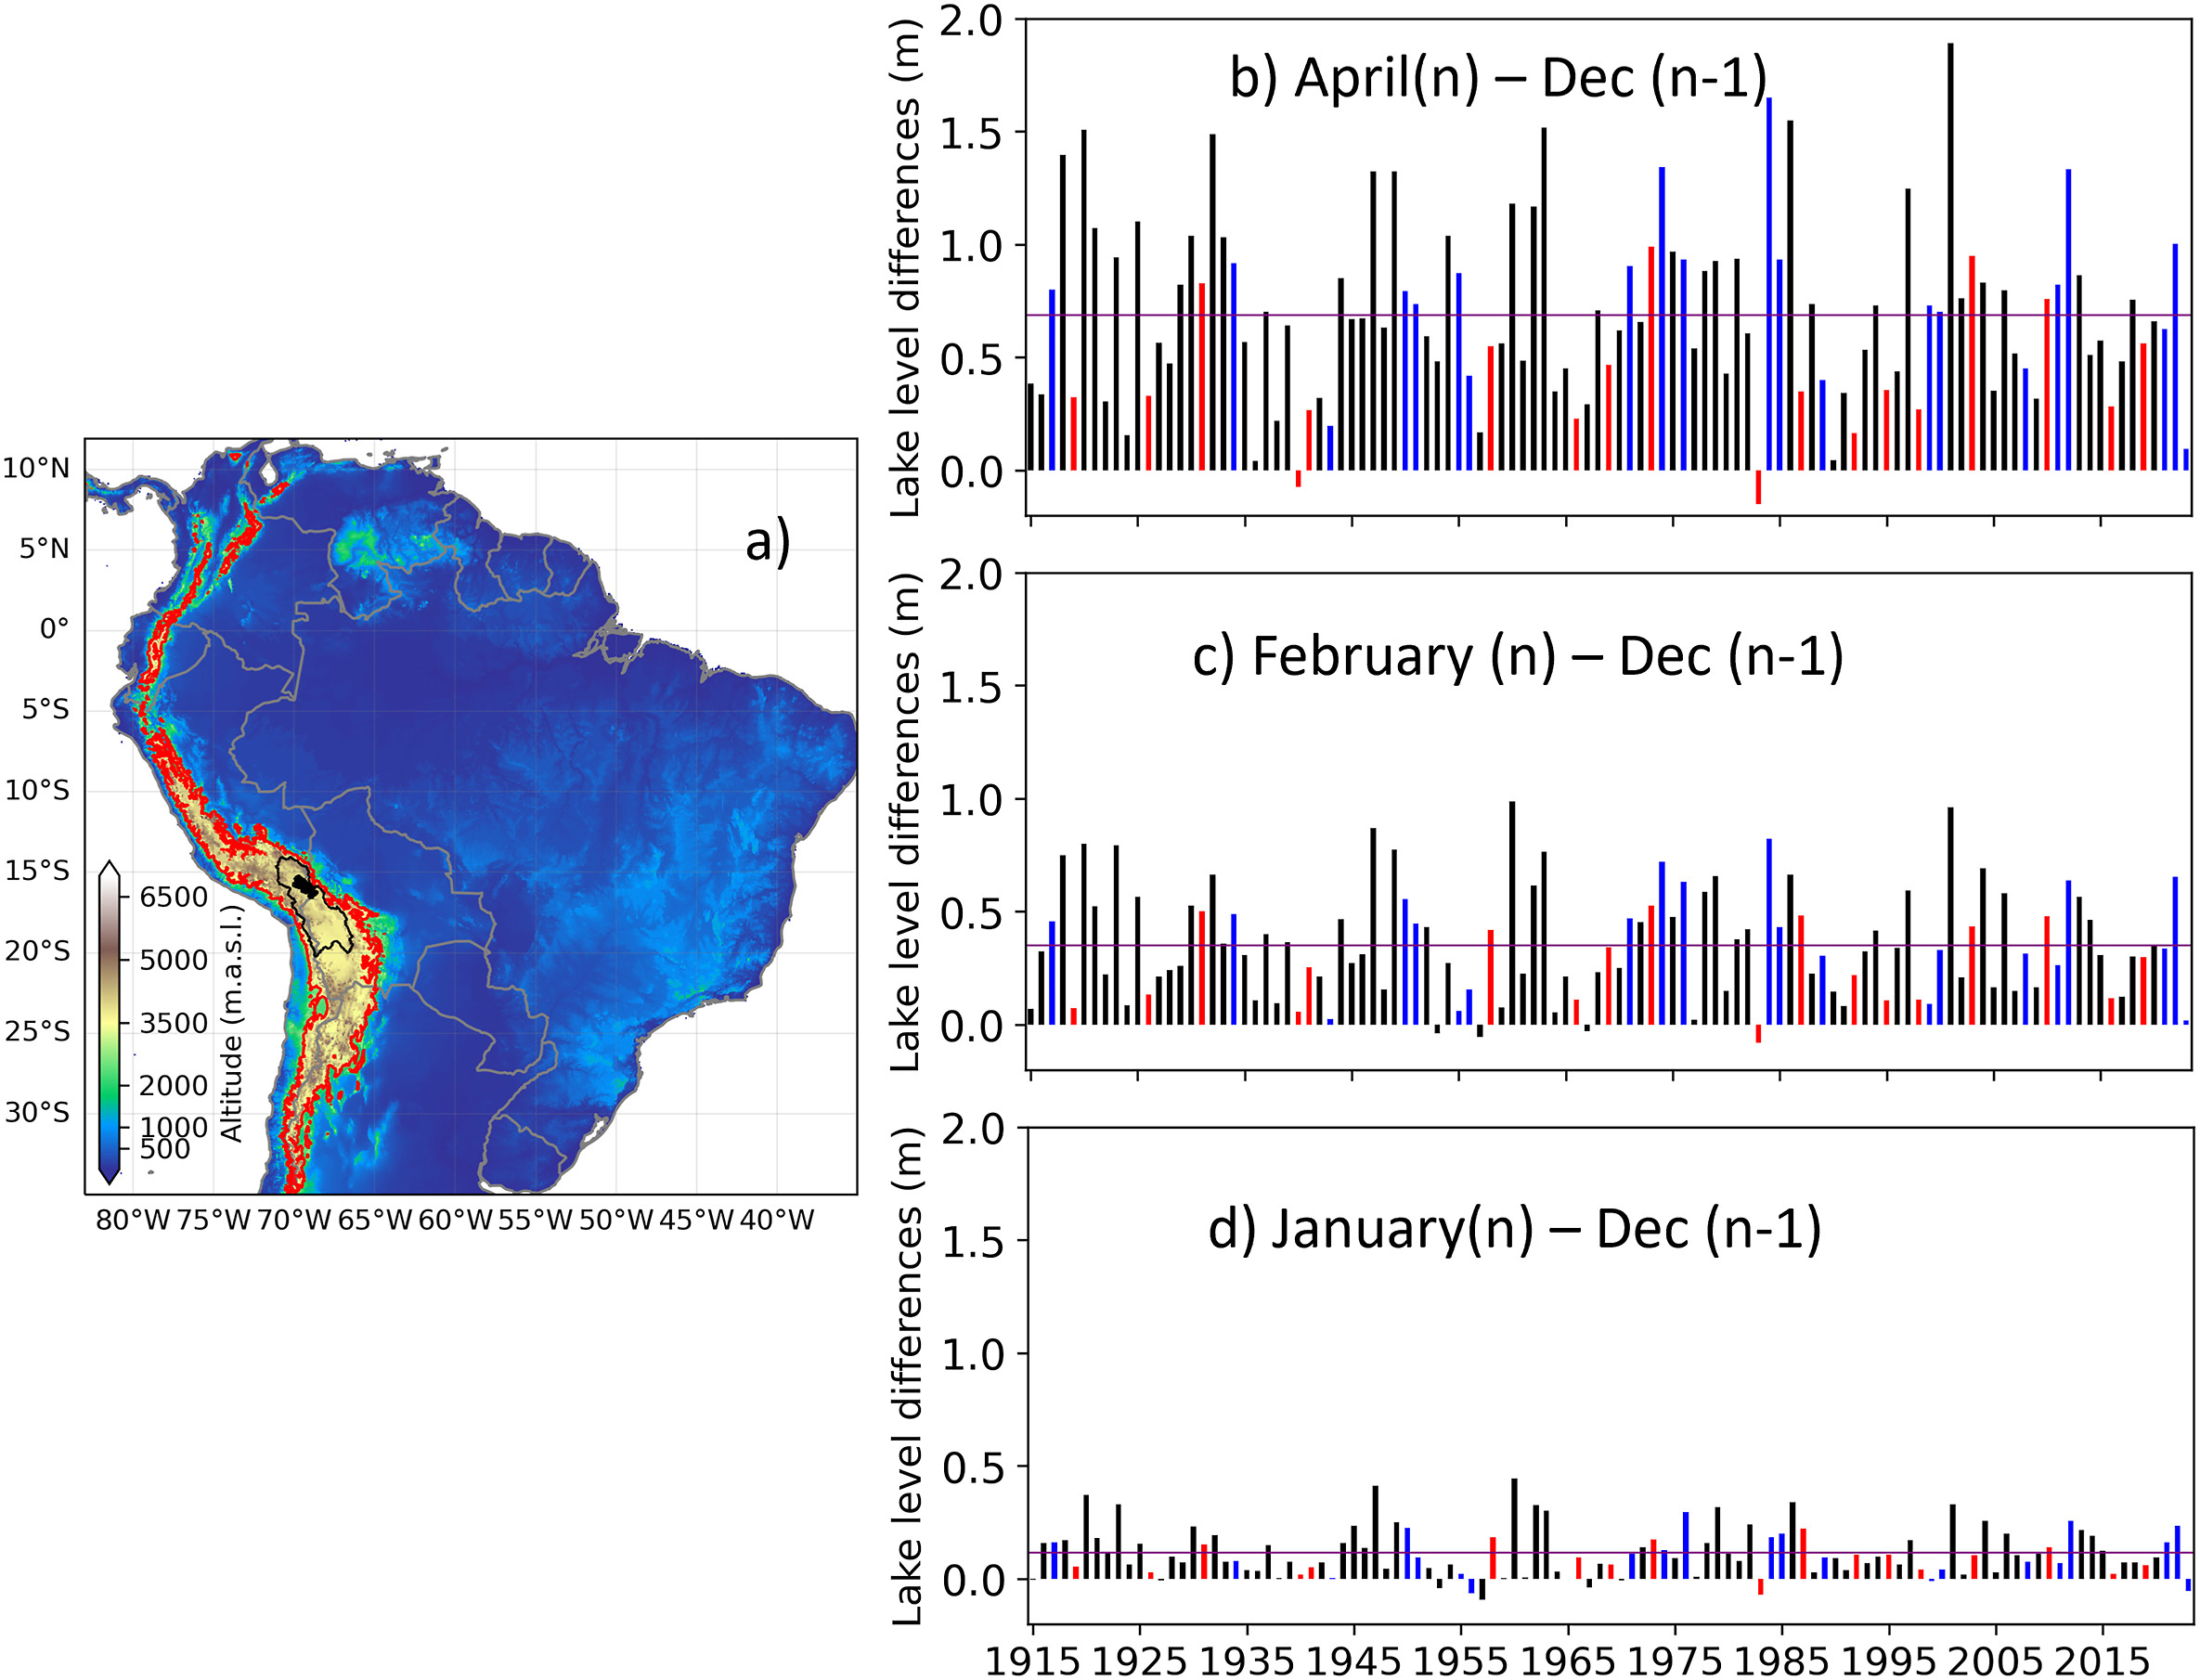

In [10]:
# Load Niño 3.4 SST Index from the HadISST1.1 (https://psl.noaa.gov/data/timeseries/month/Nino34/)
csv_url = "https://psl.noaa.gov/data/timeseries/month/data/nino34.long.anom.csv"
with fsspec.open(f"simplecache::{csv_url}") as file:
    df_enso = pd.read_csv(file)
df_enso.rename(columns={df_enso.columns[1]: "nina34"}, inplace=True)

In [11]:
# Extract April and December data
feb_values = da.sel(time=da.time.dt.month == 2)
jan_values = da.sel(time=da.time.dt.month == 1)

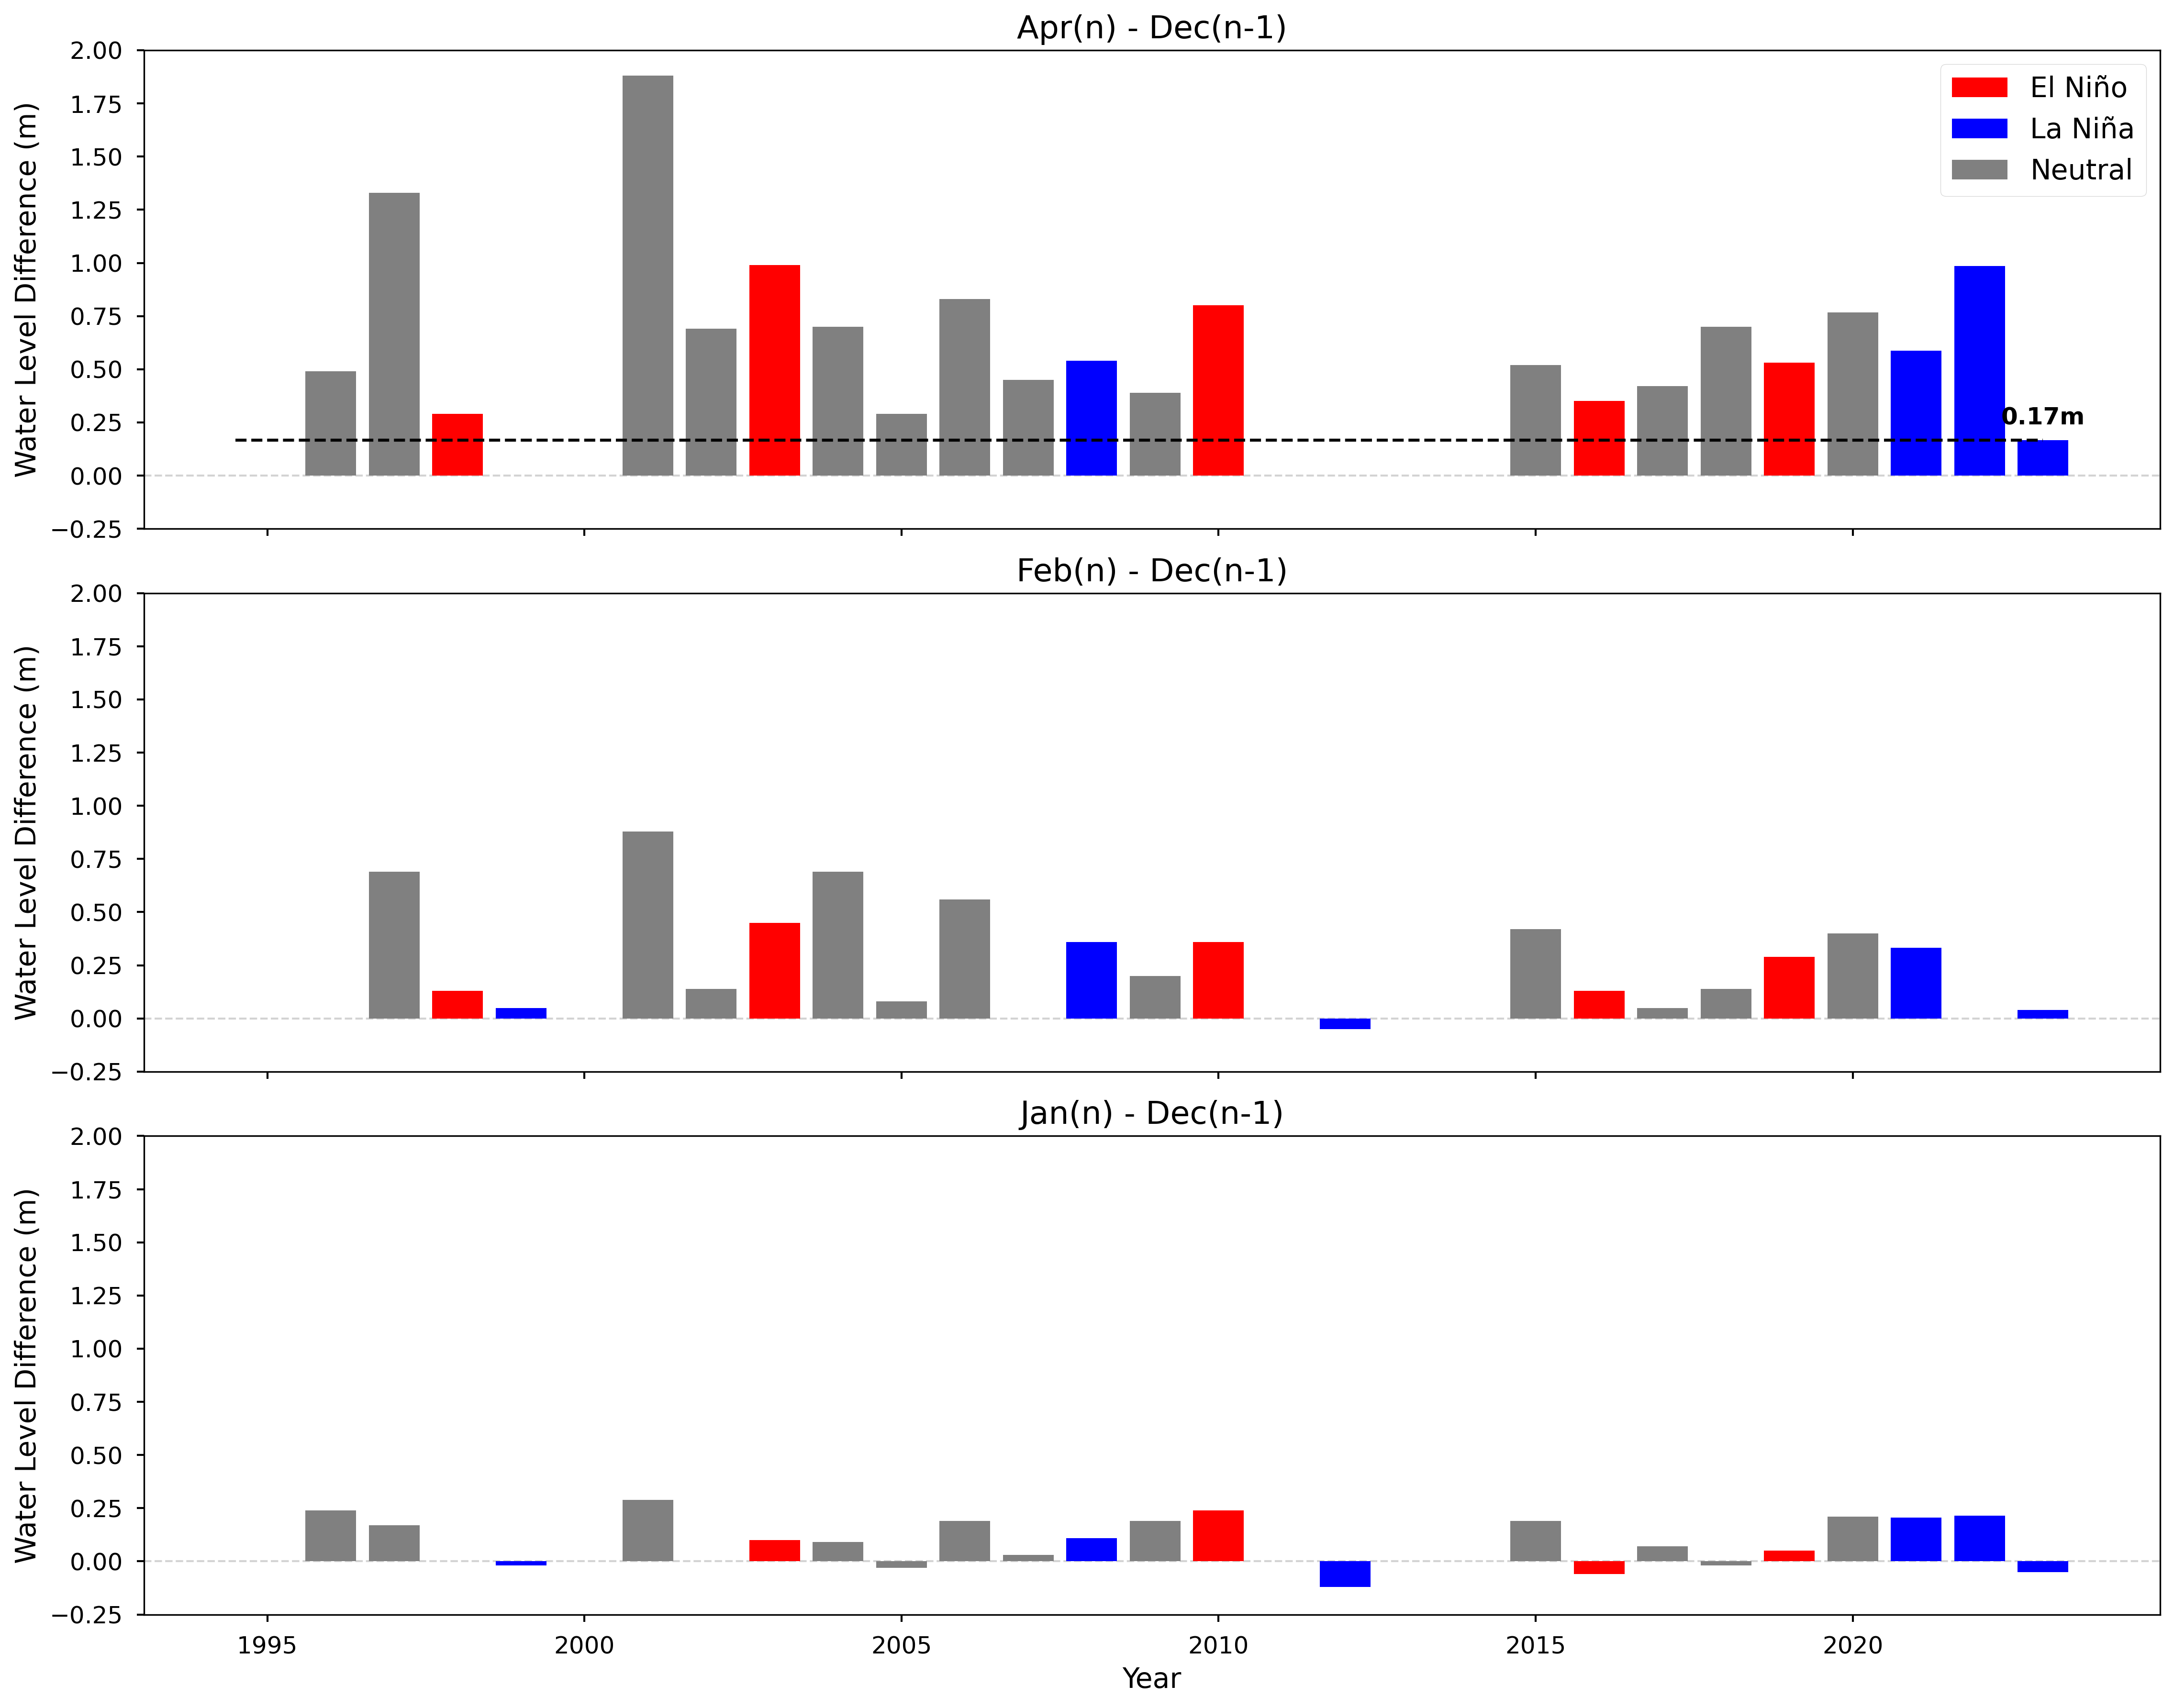

In [12]:
# Rename ENSO column
df_enso['Date'] = pd.to_datetime(df_enso['Date'])
df_enso.set_index('Date', inplace=True)
df_enso.replace(-9999.0, np.nan, inplace=True)

# Function to compute differences and ENSO-colored bar data
def compute_diffs(month_values, dec_values, label):
    # Mean per year
    month_df = month_values.to_dataframe(name='value').reset_index()
    month_df['year'] = month_df['time'].dt.year
    month_mean = month_df.groupby('year')['value'].mean()

    dec_df = dec_values.to_dataframe(name='value').reset_index()
    dec_df['year'] = dec_df['time'].dt.year
    dec_mean = dec_df.groupby('year')['value'].mean()

    # Calculate difference
    diffs = []
    years = []
    for y in range(1995, 2024):  # Full year range
        if y in month_mean and (y - 1) in dec_mean:
            diffs.append(month_mean[y] - dec_mean[y - 1])
            years.append(y)

    diff_series = pd.Series(diffs, index=years)

    # Compute ENSO-based bar colors
    colors = []
    for year in diff_series.index:
        months = pd.date_range(start=f'{year-1}-10-01', end=f'{year}-04-30', freq='MS')
        nina_vals = df_enso.loc[months, 'nina34'].dropna()
        nino_count = (nina_vals > 0.75).sum()
        nina_count = (nina_vals < -0.75).sum()

        if nino_count >= 4:
            colors.append('red')
        elif nina_count >= 4:
            colors.append('blue')
        else:
            colors.append('gray')

    # Identify missing years
    all_years = set(range(1995, 2024))
    missing_years = sorted(all_years - set(diff_series.index))

    return diff_series, colors, missing_years

# Compute all three
diff_apr, colors_apr, missing_apr = compute_diffs(april_values, december_values, "April")
diff_feb, colors_feb, missing_feb = compute_diffs(feb_values, december_values, "February")
diff_jan, colors_jan, missing_jan = compute_diffs(jan_values, december_values, "January")

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
fig.set_dpi(300)  # Set the display DPI for the figure
for i, (ax, diff, colors, label) in enumerate(zip(axes, 
                                                  [diff_apr, diff_feb, diff_jan],
                                                  [colors_apr, colors_feb, colors_jan],
                                                  ['Apr(n) - Dec(n-1)', 'Feb(n) - Dec(n-1)', 'Jan(n) - Dec(n-1)'])):
    ax.bar(diff.index, diff.values, color=colors)
    ax.set_ylabel("Water Level Difference (m)", fontsize=14)
    ax.set_title(label, fontsize=16)
    ax.set_ylim(-0.25, 2)
    ax.tick_params(axis='both', labelsize=12)
    ax.axhline(0, color='lightgray', linewidth=1, linestyle='--', zorder=0)

    # Only for the April plot, add marker and text
    if i == 0 and 2023 in diff.index:
        y_val = diff[2023]
        # Horizontal line from y-axis to the bar at y_val
        ax.hlines(y=y_val, xmin=1994.5, xmax=2023, colors='black', linestyles='--', linewidth=1.5)
        # Add text above the 2023 bar
        ax.text(2023, y_val + 0.05, f"{y_val:.2f}m", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Shared x-label
axes[-1].set_xlabel("Year", fontsize=14)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='El Niño'),
                   Patch(facecolor='blue', label='La Niña'),
                   Patch(facecolor='gray', label='Neutral')]
axes[0].legend(handles=legend_elements, loc='upper right', fontsize=14)

plt.tight_layout()
plt.show()

```{figure}
---
name: fig-enso
figwidth: 100%
---
Yearly differences between water levels of the Titicaca Lake form the C3S-LWL v5.0 dataset in April, February, and January of year *n* and December of year *n-1*, for the period 1995-2023. Bars are color-coded based on ENSO conditions between October *n-1* and April *n*: red for El Niño years (≥ 4 months with Niño 3.4 index > 0.75), blue for La Niña years (≥ 4 months with index < −0.75), and gray for neutral years. Missing bars indicate years where data was unavailable for the respective months.

```

In [13]:
# Print missing years for each
print("Missing years (no data for Apr(n) or Dec(n-1)):", missing_apr)
print("Missing years (no data for Feb(n) or Dec(n-1)):", missing_feb)
print("Missing years (no data for Jan(n) or Dec(n-1)):", missing_jan)

Missing years (no data for Apr(n) or Dec(n-1)): [1995, 1999, 2000, 2011, 2012, 2013, 2014]
Missing years (no data for Feb(n) or Dec(n-1)): [1995, 1996, 2000, 2007, 2011, 2013, 2014, 2022]
Missing years (no data for Jan(n) or Dec(n-1)): [1995, 1998, 2000, 2011, 2013, 2014]


In the work of Gutierrez-Villarreal et al. (2024) (see {numref}`fig-gutierrez`), the blue bars representing La Niña years are generally taller than the red bars representing El Niño years. This suggests that water level gains during the wet season tend to be greater during La Niña years. Such a trend is clearly visible thanks to the extensive temporal coverage of the SENAMHI dataset, which spans more than 100 years. In contrast, this pattern is not noticeable on {numref}`fig-enso`, which uses the C3S-LWL v5.0 dataset. This is likely due to the shorter time span of the C3S dataset and the presence of data gaps, resulting in missing values for several years.

Additionally, some inconsistencies between the two figures can be noted. For instance, in 2012, {numref}`fig-enso` shows slightly negative differences for both Jan(*n*)-Dec(*n-1*) and Feb(*n*)-Dec(*n-1*), while according to the SENAMHI dataset (see {numref}`fig-gutierrez`) these differences are clearly positive. This discrepancy indicates that the C3S-LWL v5.0 dataset may not be sufficiently accurate for these types of analyses, especially prior to 2016. As mentioned earlier, satellite instrument quality and measurement accuracy have improved significantly since 2016, which may explain some of the observed inconsistencies.

Despite these limitations, the C3S-LWL v5.0 dataset successfully captures the small negative difference in Jan(*n*)-Dec(*n-1*) for the year 2023, as well as the anomalously weak water level increase during the 2022-2023 wet season (see {numref}`fig-enso`). However, according to the C3S-LWL v5.0 dataset, the rise was 0.17 m, while the SENAMHI dataset recorded a lower value of 0.09 m. Although not identical, this similarity suggests that the C3S-LWL v5.0 dataset has some utility in identifying recent anomalies, even if it is not yet robust enough for long-term ENSO-related hydrological analysis in Lake Titicaca.

(section-4)=
### 4. Applicability for other lakes

In [14]:
#Load PQAR table
columns = [
    "Lake name",
    "Dispersion 1992-2023 (cm)",
    "High Frequency variation 1992-2023 (cm)",
    "Median Timestep 1992-2023 (days)",
    "Max Timestep 1992-2023 (days)",
    "Timeseries duration 1992-2023",
    "Dispersion 2014-2023 (cm)",
    "High Frequency variation 2014-2023 (cm)",
    "Median Timestep 2014-2023 (days)",
    "Max Timestep 2014-2023 (days)",
]
data = [
    ["Albert", 8.0, 3.32, 26.47, 76.81, 28.5, 6.0, 3.24, 13.0, 76.81],
    ["Bagre", 20.0, 8.65, 9.98, 99.01, 15.3, 18.0, 8.71, 9.98, 89.25],
    ["Bankim", 39.0, 11.03, 9.41, 50.84, 15.5, 9.0, 12.29, 9.31, 50.84],
    ["Bogoria", 13.0, 0.26, 27.0, 55.78, 7.8, 13.0, 0.26, 27.0, 55.78],
    ["Fitri", 10.0, 0.32, 27.0, 70.0, 10.6, 10.0, 0.33, 27.0, 70.0],
    ["George", 3.0, 0.37, 27.0, 81.0, 4.8, 3.0, 0.37, 27.0, 81.0],
    ["Kainji", 22.0, 9.87, 10.22, 113.27, 31.1, 17.0, 11.45, 9.92, 109.07],
    ["Kossou", 59.0, 0.96, 27.0, 136.61, 7.8, 59.0, 0.96, 27.0, 136.61],
    ["Kyoga", 6.0, 6.03, 9.5, 105.85, 31.2, 5.0, 7.1, 7.03, 17.68],
    ["Lagdo", 25.0, 7.1, 29.0, 145.07, 21.4, 13.5, 1.51, 27.0, 145.07],
    ["Langano", 8.0, 0.19, 27.0, 29.41, 7.8, 8.0, 0.19, 27.0, 29.41],
    ["Mangbeto", 14.0, 2.66, 27.0, 54.0, 7.8, 14.0, 2.66, 27.0, 54.0],
    ["Nasser", 10.0, 7.9, 4.64, 64.6, 31.2, 9.0, 8.88, 4.4, 34.4],
    ["Roseires", 14.5, 0.0, 35.0, 175.0, 28.4, 7.0, 20.21, 27.0, 104.0],
    ["Shiroro", 31.0, 20.75, 10.0, 108.0, 15.2, 29.0, 23.91, 10.0, 108.0],
    ["Tana", 4.0, 2.71, 9.92, 50.73, 31.2, 3.0, 3.38, 9.92, 29.75],
    ["Tchad", 13.0, 3.85, 9.92, 139.43, 31.2, 9.0, 4.82, 9.92, 34.4],
    ["Turkana", 3.0, 2.01, 9.92, 68.99, 31.2, 2.0, 2.4, 6.8, 19.83],
    ["Volta", 10.0, 6.31, 9.92, 176.66, 31.2, 8.0, 7.29, 9.92, 19.83],
    ["Ziway", 13.0, 7.43, 26.42, 71.82, 14.9, 12.0, 6.35, 27.0, 51.37],
    ["Azhibeksorkoli", 3.0, 0.29, 27.0, 108.0, 4.9, 3.0, 0.29, 27.0, 108.0],
    ["Baikal", 4.0, 6.4, 1.02, 140.08, 31.2, 4.0, 6.86, 0.98, 28.47],
    ["Baunt", 4.0, 1.71, 27.0, 54.0, 4.9, 4.0, 1.71, 27.0, 54.0],
    ["Bratskoye", 5.0, 10.62, 3.71, 100.01, 31.2, 5.0, 11.85, 1.31, 34.31],
    ["Chlya", 4.0, 1.22, 27.0, 54.0, 4.9, 4.0, 1.22, 27.0, 54.0],
    ["Chukochye", 5.0, 5.6, 25.63, 55.83, 7.8, 5.0, 5.6, 25.63, 55.83],
    ["Hovsgol", 5.0, 9.4, 12.26, 218.71, 31.2, 3.0, 12.2, 6.26, 160.6],
    ["Krasnoyarskoye", 15.0, 20.4, 5.24, 114.32, 21.2, 16.0, 23.0, 4.67, 114.32],
    ["Kulundinskoye", 13.0, 0.74, 27.0, 106.51, 7.7, 13.0, 0.74, 27.0, 106.51],
    ["Novosibirskoye", 12.5, 9.91, 9.92, 270.1, 29.4, 9.0, 11.51, 7.14, 110.63],
    ["Tchany", 28.0, 4.3, 10.03, 105.85, 29.5, 32.0, 5.72, 9.92, 69.41],
    ["Teletskoye", 2.0, 0.69, 27.0, 54.0, 5.0, 2.0, 0.69, 27.0, 54.0],
    ["Tengiz", 9.0, 2.28, 27.07, 197.0, 21.1, 22.0, 1.72, 26.93, 70.0],
    ["Uvs", 10.0, 2.5, 27.36, 249.48, 28.5, 9.0, 2.57, 25.44, 55.83],
    ["Zeyskoye", 7.0, 13.58, 12.57, 208.29, 31.2, 4.0, 17.54, 9.04, 138.82],
    ["Bolmen", 11.0, 0.29, 27.0, 81.0, 5.0, 11.0, 0.29, 27.0, 81.0],
    ["Illmen", 9.0, 6.37, 24.73, 102.2, 28.6, 5.0, 4.95, 7.42, 82.47],
    ["Inarinjarvi", 11.0, 7.05, 23.0, 105.0, 21.1, 12.0, 3.22, 12.63, 71.0],
    ["Kubenskoye", 7.0, 9.6, 11.58, 64.0, 7.8, 7.0, 9.6, 11.58, 64.0],
    ["Kumskoye", 12.0, 4.39, 10.01, 70.0, 21.5, 9.0, 3.59, 10.03, 53.87],
    ["Kuybyshevskoye", 6.0, 10.0, 9.49, 121.55, 31.2, 4.5, 12.08, 4.57, 29.75],
    ["Ladoga", 4.0, 4.12, 2.97, 89.06, 31.2, 4.0, 4.62, 2.19, 27.0],
    ["Onega", 5.0, 5.03, 3.51, 119.72, 31.2, 4.0, 5.73, 1.79, 18.04],
    ["Peipus", 4.0, 5.38, 9.92, 54.75, 31.2, 3.0, 6.7, 7.63, 20.01],
    ["Pyaozero", 51.0, 3.42, 17.61, 105.0, 21.4, 16.0, 3.03, 26.57, 70.16],
    ["Rybinskoye", 5.0, 8.28, 4.82, 91.25, 31.3, 4.0, 9.27, 2.8, 16.53],
    ["Saratovskoye", 10.0, 6.95, 9.98, 96.65, 31.2, 7.5, 8.22, 9.92, 49.58],
    ["Segozerskoye", 17.0, 4.55, 10.0, 161.6, 21.4, 10.0, 4.78, 9.98, 89.63],
    ["Umbozero", 9.0, 0.25, 27.0, 81.0, 7.8, 9.0, 0.25, 27.0, 81.0],
    ["Vanajanselka", 13.5, 0.24, 27.0, 108.0, 7.8, 13.5, 0.24, 27.0, 108.0],
    ["Vanerm", 3.0, 2.63, 6.86, 84.32, 31.2, 2.0, 3.05, 4.0, 20.45],
    ["Vattern", 8.0, 0.54, 26.79, 127.58, 7.8, 8.0, 0.54, 26.79, 127.58],
    ["Amadjuak", 10.0, 14.84, 8.82, 73.25, 29.5, 10.0, 19.0, 8.82, 19.83],
    ["Athabasca", 6.0, 8.29, 2.97, 65.7, 31.3, 5.0, 9.24, 2.56, 16.09],
    ["Atlin", 55.0, 3.64, 18.0, 54.0, 15.0, 50.0, 4.27, 25.42, 54.0],
    ["Aylmer", 7.0, 4.81, 9.92, 97.09, 31.2, 5.0, 6.07, 9.06, 50.0],
    ["Baker", 7.0, 6.98, 9.92, 122.64, 31.2, 7.0, 8.93, 9.92, 25.07],
    ["Bienville", 14.0, 6.82, 9.64, 105.0, 21.5, 12.0, 6.79, 8.1, 51.82],
    ["Big-Trout", 7.0, 4.56, 14.0, 53.82, 7.8, 7.0, 4.56, 14.0, 53.82],
    ["Birch", 8.0, 3.33, 16.6, 91.4, 7.8, 8.0, 3.33, 16.6, 91.4],
    ["Black", 7.0, 3.92, 27.0, 54.0, 7.8, 7.0, 3.92, 27.0, 54.0],
    ["Bluenose", 14.5, 4.43, 16.38, 81.27, 7.7, 14.5, 4.43, 16.38, 81.27],
    ["Caribou", 12.0, 4.49, 9.92, 65.88, 31.2, 12.0, 5.79, 7.19, 39.66],
    ["Cedar", 10.0, 5.18, 9.92, 66.25, 31.2, 8.0, 6.27, 9.92, 29.75],
    ["Churchill", 13.0, 2.98, 26.81, 54.06, 5.0, 13.0, 2.98, 26.81, 54.06],
    ["Claire", 13.0, 3.28, 21.42, 65.42, 7.8, 13.0, 3.28, 21.42, 65.42],
    ["Cormorant", 10.0, 2.44, 27.2, 113.37, 13.4, 11.0, 2.3, 27.0, 84.57],
    ["Cumberland", 21.0, 3.32, 26.72, 79.76, 7.8, 21.0, 3.32, 26.72, 79.76],
    ["Dubawnt", 14.0, 4.64, 9.92, 70.0, 21.5, 15.0, 5.01, 9.47, 39.66],
    ["Faber", 12.0, 3.85, 10.6, 52.4, 7.8, 12.0, 3.85, 10.6, 52.4],
    ["Gods", 19.0, 4.96, 9.92, 107.43, 21.5, 16.0, 4.53, 9.92, 49.58],
    ["Grande_Trois", 7.0, 13.34, 7.64, 69.71, 31.2, 6.0, 15.95, 2.77, 12.39],
    ["Greatslave", 6.0, 9.87, 1.18, 124.1, 31.2, 5.0, 10.51, 1.18, 12.41],
    ["Hottah", 23.0, 6.93, 9.98, 140.0, 21.5, 17.0, 8.29, 9.0, 59.79],
    ["Iliamna", 9.0, 9.01, 3.74, 78.24, 21.4, 8.0, 9.81, 2.58, 70.26],
    ["Kamilukuak", 4.0, 3.5, 14.0, 108.0, 7.8, 4.0, 3.5, 14.0, 108.0],
    ["Kasba", 8.0, 8.83, 9.14, 98.38, 21.2, 7.0, 9.49, 2.01, 68.79],
    ["Manitoba", 6.0, 6.38, 9.85, 120.74, 23.9, 6.0, 7.54, 6.54, 29.75],
    ["Nueltin", 16.0, 8.94, 9.85, 98.82, 29.4, 10.0, 11.66, 9.14, 59.49],
    ["Old-Wives", 6.0, 3.08, 25.44, 29.41, 7.8, 6.0, 3.08, 25.44, 29.41],
    ["Swan", 5.0, 0.75, 27.0, 54.0, 5.0, 5.0, 0.75, 27.0, 54.0],
    ["Teshekpuk", 6.0, 1.82, 17.0, 54.0, 7.7, 6.0, 1.82, 17.0, 54.0],
    ["Tustumena", 24.0, 3.9, 26.96, 107.71, 7.8, 24.0, 3.9, 26.96, 107.71],
    ["Williston", 7.0, 23.33, 8.66, 143.08, 31.1, 5.0, 27.36, 8.65, 97.9],
    ["Winnipegosis", 15.0, 8.42, 9.92, 77.75, 21.2, 14.0, 9.91, 9.92, 76.18],
    ["Winnipeg", 5.0, 9.83, 2.28, 91.25, 31.2, 5.0, 10.73, 1.31, 33.48],
    ["Argyle", 26.0, 10.9, 26.52, 137.51, 21.5, 11.0, 8.02, 25.74, 52.73],
    ["Corangamite", 12.5, 0.23, 27.0, 81.0, 4.9, 12.5, 0.23, 27.0, 81.0],
    ["Pukaki", 82.0, 1.49, 27.0, 81.0, 7.8, 82.0, 1.49, 27.0, 81.0],
    ["Bangweulu", 11.0, 2.39, 27.45, 139.59, 28.4, 8.0, 2.52, 23.49, 104.22],
    ["Cahora_Bassa", 10.0, 8.24, 9.92, 73.0, 21.2, 9.0, 8.33, 9.92, 59.49],
    ["Chishi", 9.0, 3.03, 24.51, 51.02, 7.8, 9.0, 3.03, 24.51, 51.02],
    ["Edouard", 8.0, 1.8, 28.43, 255.57, 28.6, 6.0, 0.79, 13.5, 87.82],
    ["Hendrik-Verwoerd", 9.0, 12.68, 20.53, 81.0, 7.6, 9.0, 12.68, 20.53, 81.0],
    ["Kabele", 13.0, 0.43, 27.0, 55.83, 7.8, 13.0, 0.43, 27.0, 55.83],
    ["Kabwe", 15.0, 0.53, 27.0, 55.83, 7.8, 15.0, 0.53, 27.0, 55.83],
    ["Kariba", 2.0, 21.57, 8.38, 99.28, 31.2, 2.0, 25.61, 4.0, 28.22],
    ["Kinkony", 6.5, 0.9, 27.0, 54.0, 4.9, 6.5, 0.9, 27.0, 54.0],
    ["Kisale", 5.0, 0.99, 27.0, 54.0, 4.9, 5.0, 0.99, 27.0, 54.0],
    ["Kivu", 12.0, 0.0, 34.4, 314.57, 28.6, 8.5, 1.14, 25.49, 104.26],
    ["Mai-Ndombe", 13.0, 6.41, 17.5, 54.0, 7.8, 13.0, 6.41, 17.5, 54.0],
    ["Malawi", 5.0, 3.86, 3.5, 89.06, 31.2, 4.0, 4.35, 2.45, 12.39],
    ["Mweru", 3.0, 3.15, 9.92, 58.93, 31.2, 2.0, 3.74, 8.27, 23.41],
    ["Naivasha", 17.0, 4.06, 26.42, 188.4, 15.4, 15.5, 3.82, 27.0, 81.27],
    ["Rukwa", 2.0, 3.95, 9.92, 188.7, 31.2, 2.0, 4.79, 7.77, 29.75],
    ["Sulunga", 3.0, 3.36, 27.0, 27.0, 4.3, 3.0, 3.36, 27.0, 27.0],
    ["Tanganika", 8.0, 3.96, 6.1, 61.69, 31.2, 5.0, 4.63, 2.7, 23.0],
    ["Tumba", 10.5, 0.79, 27.0, 189.0, 6.7, 10.5, 0.79, 27.0, 189.0],
    ["Victoria", 2.0, 1.94, 4.9, 61.68, 31.2, 2.0, 2.24, 4.0, 12.39],
    ["Zimbambo", 22.5, 0.53, 27.0, 80.93, 7.8, 22.5, 0.53, 27.0, 80.93],
    ["Bodensee", 9.0, 0.5, 27.0, 54.0, 7.8, 9.0, 0.5, 27.0, 54.0],
    ["Kremenchutska", 6.0, 10.42, 5.56, 115.75, 31.2, 5.0, 12.0, 2.82, 28.96],
    ["Leman", 5.0, 3.59, 23.45, 54.0, 7.5, 5.0, 3.59, 23.45, 54.0],
    ["Prespa", 7.0, 0.28, 27.0, 54.0, 7.7, 7.0, 0.28, 27.0, 54.0],
    ["Rosarito", 8.0, 1.48, 27.0, 81.0, 4.7, 8.0, 1.48, 27.0, 81.0],
    ["Tsimlyanskoye", 9.0, 8.35, 5.8, 123.73, 31.2, 7.0, 9.58, 2.64, 20.08],
    ["Americanfalls", 3.0, 2.42, 27.0, 54.0, 3.9, 3.0, 2.42, 27.0, 54.0],
    ["Cayuga", 2.0, 0.59, 27.0, 81.0, 4.9, 2.0, 0.59, 27.0, 81.0],
    ["Chapala", 4.0, 4.58, 26.48, 89.24, 12.8, 5.0, 4.61, 26.48, 89.24],
    ["Des_Bois", 6.0, 5.16, 9.59, 125.56, 31.2, 4.0, 6.28, 4.29, 75.44],
    ["Erie", 2.0, 3.65, 2.48, 116.02, 31.3, 2.0, 4.01, 1.62, 116.02],
    ["Fort_Peck", 5.5, 13.8, 9.92, 226.3, 31.1, 2.0, 17.0, 9.92, 150.06],
    ["Huron", 3.0, 3.09, 2.06, 69.28, 31.2, 2.0, 3.36, 1.46, 69.28],
    ["Michigan", 3.0, 3.34, 1.62, 64.6, 31.2, 3.0, 3.64, 1.45, 31.46],
    ["Mono", 21.0, 0.13, 27.0, 245.0, 10.5, 20.0, 0.14, 27.0, 245.0],
    ["Mullet", 5.0, 0.42, 27.0, 54.0, 7.6, 5.0, 0.42, 27.0, 54.0],
    ["Nezahualcoyoti", 27.0, 0.0, 35.38, 247.64, 28.4, 11.0, 1.69, 27.0, 189.0],
    ["Nicaragua", 3.0, 2.88, 9.92, 62.05, 31.2, 2.0, 3.58, 7.07, 16.03],
    ["Nipissing", 9.0, 5.49, 9.45, 121.27, 7.8, 9.0, 5.49, 9.45, 121.27],
    ["Oahe", 22.0, 12.91, 26.4, 383.34, 28.6, 17.5, 13.45, 7.55, 182.19],
    ["Okeechobee", 17.0, 0.0, 35.0, 112.0, 28.5, 22.5, 0.46, 27.0, 108.0],
    ["Ontario", 2.0, 3.44, 1.78, 62.78, 31.2, 2.0, 3.79, 1.62, 19.47],
    ["Saint_Jean", 14.5, 10.53, 9.98, 135.78, 31.2, 13.0, 12.81, 9.92, 71.78],
    ["Sakakawea", 4.0, 16.04, 7.28, 197.47, 31.2, 3.0, 18.6, 4.1, 29.75],
    ["Superior", 2.0, 3.0, 1.34, 65.7, 31.3, 2.0, 3.17, 1.16, 58.86],
    ["Walker", 11.5, 0.33, 27.0, 313.0, 10.7, 11.0, 0.34, 27.0, 313.0],
    ["Yellowstone", 9.0, 7.94, 9.98, 418.75, 31.2, 9.0, 9.08, 9.92, 29.75],
    ["Achit", 4.0, 1.06, 27.0, 81.0, 4.9, 4.0, 1.06, 27.0, 81.0],
    ["Aqqikol-Hu", 7.0, 0.16, 27.0, 55.83, 7.8, 7.0, 0.16, 27.0, 55.83],
    ["Ayakkum", 5.0, 3.12, 16.39, 765.15, 28.5, 5.0, 2.41, 14.54, 145.7],
    ["Barkal", 1.0, 10.21, 27.0, 113.0, 13.3, 1.0, 9.99, 27.0, 113.0],
    ["Bay", 20.0, 3.7, 25.67, 34.37, 5.0, 20.0, 3.7, 25.67, 34.37],
    ["Boontsagaan", 10.0, 0.0, 35.0, 152.17, 21.3, 10.0, 1.7, 27.0, 152.17],
    ["Bosten", 15.0, 4.96, 9.98, 73.0, 21.2, 14.0, 6.03, 9.92, 69.21],
    ["Chlew-Larn", 17.0, 22.84, 27.0, 124.0, 12.9, 18.0, 2.76, 27.0, 86.0],
    ["Cuodarima", 1.0, 4.47, 9.92, 158.65, 7.1, 1.0, 4.47, 9.92, 158.65],
    ["Dagze-Co", 6.0, 6.85, 27.0, 357.33, 30.9, 3.0, 4.77, 27.0, 118.65],
    ["Dalai", 11.0, 0.13, 27.0, 54.4, 7.8, 11.0, 0.13, 27.0, 54.4],
    ["Danau-Towuti", 34.0, 5.51, 27.0, 105.0, 21.1, 14.0, 1.46, 27.0, 69.0],
    ["Danausingkarak", 2.0, 0.51, 27.0, 54.0, 4.8, 2.0, 0.51, 27.0, 54.0],
    ["Dangqiong", 2.0, 0.27, 27.0, 81.0, 7.8, 2.0, 0.27, 27.0, 81.0],
    ["Dogaicoring-Q", 3.0, 2.66, 27.0, 912.04, 21.2, 3.0, 3.13, 27.0, 211.51],
    ["Dorgon", 7.0, 4.85, 5.72, 36.84, 7.7, 7.0, 4.85, 5.72, 36.84],
    ["Dorsoidong-Co", 8.0, 0.18, 27.0, 140.37, 10.8, 9.5, 0.19, 27.0, 140.37],
    ["Garkung", 3.0, 0.23, 27.0, 81.0, 7.6, 3.0, 0.23, 27.0, 81.0],
    ["Gyaring-Co", 8.0, 0.35, 27.0, 53.97, 7.8, 8.0, 0.35, 27.0, 53.97],
    ["Hala", 8.0, 2.15, 27.0, 118.0, 12.9, 9.0, 0.12, 27.0, 105.0],
    ["Har", 11.0, 3.34, 10.35, 296.81, 31.2, 11.0, 2.81, 9.98, 296.81],
    ["Hoh-Xil-Hu", 6.0, 1.41, 21.47, 80.24, 7.8, 6.0, 1.41, 21.47, 80.24],
    ["Hongze", 29.0, 6.51, 10.02, 95.26, 31.2, 24.5, 7.12, 9.92, 39.66],
    ["Hulun", 8.0, 5.28, 9.59, 84.9, 30.7, 6.0, 6.5, 9.59, 84.9],
    ["Hyargas", 8.0, 2.43, 23.21, 145.65, 28.6, 5.0, 1.89, 10.0, 145.65],
    ["Khanka", 6.0, 5.3, 9.98, 163.88, 22.2, 5.0, 5.94, 9.92, 108.23],
    ["Kokonor", 9.0, 4.51, 27.48, 246.38, 28.5, 8.0, 0.54, 27.0, 80.29],
    ["Lano", 7.0, 0.37, 27.0, 189.0, 7.8, 7.0, 0.37, 27.0, 189.0],
    ["Lixiodain-Co", 7.5, 4.1, 27.0, 804.0, 26.6, 8.0, 4.49, 27.0, 208.92],
    ["Migriggyangzham", 4.0, 8.37, 9.92, 357.54, 30.9, 2.0, 5.1, 9.92, 357.54],
    ["Namco", 4.0, 4.81, 27.0, 151.33, 28.6, 4.0, 2.03, 27.0, 138.61],
    ["Namngum", 6.0, 1.8, 27.0, 27.0, 5.0, 6.0, 1.8, 27.0, 27.0],
    ["Ngangze", 6.0, 12.11, 9.92, 249.66, 31.2, 4.0, 5.35, 9.92, 69.41],
    ["Ngoring-Co", 7.0, 10.7, 18.61, 178.85, 31.1, 5.0, 4.16, 27.0, 104.71],
    ["Serbug", 2.5, 0.42, 27.0, 108.0, 4.9, 2.5, 0.42, 27.0, 108.0],
    ["Soungari", 12.0, 22.41, 9.92, 186.66, 29.5, 9.0, 22.46, 9.53, 68.79],
    ["Tangra-Yumco", 11.0, 7.88, 23.47, 214.62, 28.5, 12.0, 7.35, 3.53, 105.24],
    ["Telashi", 3.0, 0.34, 27.0, 81.0, 7.6, 3.0, 0.34, 27.0, 81.0],
    ["Telmen", 4.0, 0.16, 27.0, 54.0, 7.5, 4.0, 0.16, 27.0, 54.0],
    ["Tonle_Sap", 7.0, 8.25, 27.0, 105.0, 28.5, 4.0, 9.63, 16.51, 99.51],
    ["Ulan-Ul", 7.0, 4.01, 28.82, 246.37, 28.1, 10.0, 1.8, 26.82, 175.0],
    ["Ulungur", 13.0, 5.84, 9.92, 139.07, 31.2, 12.0, 7.1, 9.92, 34.35],
    ["Xiangyang", 3.0, 0.22, 27.0, 81.0, 4.9, 3.0, 0.22, 27.0, 81.0],
    ["Xuelian-Hu", 7.0, 0.63, 27.0, 81.0, 7.8, 7.0, 0.63, 27.0, 81.0],
    ["Yamzho-Yumco", 15.0, 1.48, 27.0, 55.83, 7.8, 15.0, 1.48, 27.0, 55.83],
    ["Zhari-Namco", 5.0, 6.71, 9.92, 739.76, 30.9, 4.0, 7.52, 7.59, 21.39],
    ["Zhelin", 9.0, 3.98, 27.0, 81.0, 7.7, 9.0, 3.98, 27.0, 81.0],
    ["Ziling", 3.0, 5.55, 13.69, 350.03, 28.5, 3.0, 4.5, 1.85, 139.06],
    ["Zonag", 6.0, 0.23, 27.0, 81.0, 7.6, 6.0, 0.23, 27.0, 81.0],
    ["Lagoa_Do_Patos", 3.0, 8.16, 9.92, 306.6, 31.2, 2.0, 9.88, 7.08, 29.75],
    ["Argentino", 3.0, 8.4, 6.62, 156.28, 31.2, 2.0, 9.64, 3.29, 30.39],
    ["Balbina", 6.0, 12.11, 9.92, 139.8, 31.2, 7.0, 9.96, 9.92, 49.58],
    ["Biarini", 10.0, 20.72, 27.0, 81.0, 13.2, 10.0, 18.14, 27.0, 81.0],
    ["Brokopondo", 10.0, 3.8, 27.16, 179.98, 13.4, 22.0, 3.76, 27.06, 179.98],
    ["Cabaliana", 10.0, 17.85, 27.0, 129.32, 13.4, 11.0, 13.58, 27.0, 129.32],
    ["Cardiel", 5.0, 0.12, 27.0, 27.0, 5.0, 5.0, 0.12, 27.0, 27.0],
    ["Cerros-Colorados", 12.0, 0.77, 27.0, 55.83, 7.8, 12.0, 0.77, 27.0, 55.83],
    ["Chocon", 6.0, 6.16, 23.0, 85.0, 13.4, 6.0, 6.39, 16.46, 37.38],
    ["Cienagachilloa", 4.0, 0.82, 27.0, 54.0, 7.7, 4.0, 0.82, 27.0, 54.0],
    ["Coari", 12.0, 23.67, 28.86, 113.37, 21.4, 14.5, 18.35, 27.01, 113.37],
    ["Cochrane", 11.0, 2.1, 20.01, 313.47, 15.8, 9.0, 2.32, 27.0, 97.71],
    ["Fontana", 1.0, 0.34, 27.0, 54.0, 5.0, 1.0, 0.34, 27.0, 54.0],
    ["Guri", 22.0, 8.85, 10.01, 128.9, 31.2, 25.0, 10.9, 9.92, 128.9],
    ["Hinojo", 9.0, 0.41, 27.0, 56.81, 7.8, 9.0, 0.41, 27.0, 56.81],
    ["Ranco", 6.0, 1.03, 27.0, 55.83, 7.8, 6.0, 1.03, 27.0, 55.83],
    ["San_Martin", 26.0, 15.52, 7.45, 33.37, 7.8, 26.0, 15.52, 7.45, 33.37],
    ["Sobradino", 4.0, 11.8, 15.91, 205.87, 28.5, 4.0, 11.51, 8.96, 139.64],
    ["Titicaca", 9.0, 1.98, 28.47, 142.49, 28.6, 11.0, 2.19, 14.49, 93.51],
    ["Todos_Los_Santos", 12.0, 10.25, 9.92, 1408.07, 31.2, 10.0, 10.93, 9.0, 49.58],
    ["Tres_Marias", 11.0, 0.0, 32.94, 140.0, 28.5, 1.0, 13.22, 27.0, 113.0],
    ["Valencia", 6.0, 0.24, 27.0, 54.0, 4.6, 6.0, 0.24, 27.0, 54.0],
    ["Viedma", 4.0, 3.79, 7.45, 101.68, 10.8, 4.0, 3.85, 7.45, 101.68],
    ["Alakol", 11.0, 3.82, 25.44, 78.11, 21.5, 9.0, 2.73, 17.0, 71.82],
    ["Aydarkul", 12.0, 2.73, 14.0, 85.77, 28.5, 5.0, 3.3, 6.54, 85.77],
    ["Bairab", 3.0, 0.25, 27.0, 108.0, 7.7, 3.0, 0.25, 27.0, 108.0],
    ["Balkhash", 4.0, 6.49, 2.44, 159.14, 31.3, 3.0, 7.13, 1.56, 30.39],
    ["Beas", 4.0, 4.91, 27.0, 54.0, 4.9, 4.0, 4.91, 27.0, 54.0],
    ["Beysehir", 7.0, 6.72, 9.92, 163.88, 31.2, 6.0, 7.56, 9.92, 39.66],
    ["Biylikol", 7.0, 0.51, 27.0, 81.0, 7.8, 7.0, 0.51, 27.0, 81.0],
    ["Bugunskoye", 10.0, 2.73, 27.0, 54.0, 7.6, 10.0, 2.73, 27.0, 54.0],
    ["Caspian", 3.0, 2.68, 1.45, 63.88, 31.3, 3.0, 2.87, 1.34, 20.01],
    ["Chagbo-Co", 8.0, 0.18, 27.0, 81.27, 7.6, 8.0, 0.18, 27.0, 81.27],
    ["Chardarya", 6.0, 13.86, 5.33, 98.82, 31.2, 5.0, 15.81, 4.59, 49.58],
    ["Chatyrkol", 4.0, 0.28, 27.0, 54.0, 7.7, 4.0, 0.28, 27.0, 54.0],
    ["Egridir", 8.0, 0.16, 27.0, 27.0, 4.9, 8.0, 0.16, 27.0, 27.0],
    ["Gyeze-Caka", 7.0, 0.13, 27.0, 135.0, 7.5, 7.0, 0.13, 27.0, 135.0],
    ["Habbaniyah", 4.0, 0.64, 27.0, 54.0, 5.0, 4.0, 0.64, 27.0, 54.0],
    ["Hamrin", 5.0, 1.56, 27.0, 54.0, 4.9, 5.0, 1.56, 27.0, 54.0],
    ["Hawizeh-Marshes", 5.0, 0.75, 27.0, 135.0, 4.8, 5.0, 0.75, 27.0, 135.0],
    ["Heishi-Beihu", 4.0, 0.14, 27.0, 81.0, 4.9, 4.0, 0.14, 27.0, 81.0],
    ["Issykkul", 3.0, 3.46, 9.13, 95.27, 31.2, 3.0, 3.99, 2.54, 26.38],
    ["Iznik", 10.0, 1.25, 26.98, 107.0, 10.7, 10.0, 1.27, 26.88, 107.0],
    ["Jayakwadi", 9.0, 1.36, 27.0, 54.0, 7.8, 9.0, 1.36, 27.0, 54.0],
    ["Kairakum", 20.0, 6.14, 10.05, 81.22, 15.4, 11.0, 8.85, 26.42, 81.0],
    ["Kamyshlybas", 4.0, 0.44, 27.0, 54.0, 4.9, 4.0, 0.44, 27.0, 54.0],
    ["Kapchagayskoye", 9.0, 8.57, 9.92, 187.25, 31.1, 6.0, 9.9, 9.92, 38.33],
    ["Karasor", 6.0, 5.07, 25.44, 107.69, 7.8, 6.0, 5.07, 25.44, 107.69],
    ["Kara_Bogaz_Gol", 2.0, 2.95, 5.33, 38.43, 31.2, 2.0, 3.47, 4.59, 18.72],
    ["Langa-Co", 4.0, 7.33, 9.92, 70.26, 14.7, 4.0, 7.73, 9.3, 47.26],
    ["Lumajangdong-Co", 4.5, 0.0, 34.4, 728.64, 21.0, 5.0, 0.16, 27.0, 728.64],
    ["Luotuo", 3.0, 0.49, 27.0, 54.0, 7.6, 3.0, 0.49, 27.0, 54.0],
    ["Memar", 2.0, 0.2, 27.0, 81.0, 4.9, 2.0, 0.2, 27.0, 81.0],
    ["Mingacevir", 3.0, 10.13, 26.52, 138.08, 21.3, 2.0, 12.29, 20.46, 85.0],
    ["Mossoul", 9.0, 23.06, 9.92, 179.03, 31.2, 8.0, 24.37, 9.92, 148.1],
    ["Orba-Co", 9.0, 4.02, 19.5, 189.64, 12.0, 14.0, 4.5, 25.43, 187.49],
    ["Saksak", 14.0, 16.79, 9.92, 189.8, 31.0, 6.0, 16.23, 9.92, 67.81],
    ["Sarykamish", 3.0, 2.11, 9.92, 102.78, 31.2, 3.0, 2.52, 9.92, 30.39],
    ["Sasykkol", 7.0, 2.66, 9.98, 105.0, 21.4, 6.0, 2.84, 9.92, 79.26],
    ["Saysan", 10.0, 6.89, 22.95, 357.79, 23.9, 9.5, 5.88, 17.45, 78.82],
    ["Sevan", 6.0, 3.4, 25.55, 124.39, 28.5, 5.0, 3.25, 6.54, 93.7],
    ["Srisailam", 68.0, 12.74, 27.0, 27.0, 4.8, 68.0, 12.74, 27.0, 27.0],
    ["Tharthar", 3.0, 18.2, 9.92, 63.87, 31.2, 2.0, 24.16, 9.92, 29.75],
    ["Toktogul", 14.0, 0.0, 34.44, 1006.73, 28.5, 8.0, 2.86, 27.0, 951.49],
    ["Van", 6.0, 3.39, 12.46, 73.0, 28.6, 5.0, 3.03, 10.0, 39.43],
]
df_pqar = pd.DataFrame(columns=columns, data=data)
df_pqar

,Lake name,Dispersion 1992-2023 (cm),High Frequency variation 1992-2023 (cm),Median Timestep 1992-2023 (days),Max Timestep 1992-2023 (days),Timeseries duration 1992-2023,Dispersion 2014-2023 (cm),High Frequency variation 2014-2023 (cm),Median Timestep 2014-2023 (days),Max Timestep 2014-2023 (days)
0,Albert,8.0,3.32,26.47,76.81,28.5,6.0,3.24,13.00,76.81
1,Bagre,20.0,8.65,9.98,99.01,15.3,18.0,8.71,9.98,89.25
2,Bankim,39.0,11.03,9.41,50.84,15.5,9.0,12.29,9.31,50.84
3,Bogoria,13.0,0.26,27.00,55.78,7.8,13.0,0.26,27.00,55.78
4,Fitri,10.0,0.32,27.00,70.00,10.6,10.0,0.33,27.00,70.00
...,...,...,...,...,...,...,...,...,...,...
246,Sevan,6.0,3.40,25.55,124.39,28.5,5.0,3.25,6.54,93.70
247,Srisailam,68.0,12.74,27.00,27.00,4.8,68.0,12.74,27.00,27.00
248,Tharthar,3.0,18.20,9.92,63.87,31.2,2.0,24.16,9.92,29.75
249,Toktogul,14.0,0.00,34.44,1006.73,28.5,8.0,2.86,27.00,951.49


In [15]:
# Define the columns of interest
columns_of_interest = [
    'Median Timestep 1992-2023 (days)', 
    'Max Timestep 1992-2023 (days)',
    'Timeseries duration 1992-2023', 
    'Median Timestep 2014-2023 (days)', 
    'Max Timestep 2014-2023 (days)'
]

# Get the row for Lake Titicaca
titicaca_row = df_pqar[df_pqar["Lake name"] == "Titicaca"].squeeze()

# Compute percentile ranks for Titicaca
percentile_ranks = {}
for col in columns_of_interest:
    values = df_pqar[col]
    titicaca_value = titicaca_row[col]
    percentile = (values < titicaca_value).mean() * 100
    percentile_ranks[col] = round(percentile, 2)

# Create a DataFrame for display
percentile_df = pd.DataFrame.from_dict(percentile_ranks, orient="index", columns=["Titicaca Percentile"])
print(percentile_df)

                                  Titicaca Percentile
Median Timestep 1992-2023 (days)                95.22
Max Timestep 1992-2023 (days)                   76.89
Timeseries duration 1992-2023                   66.53
Median Timestep 2014-2023 (days)                45.42
Max Timestep 2014-2023 (days)                   73.31


Since the dataset has different median timestep, maximum timestep, and timeseries duration for each lake, it is recommended to consult Annex A: LWL Performance Indicators in the PQAR [3](https://confluence.ecmwf.int/pages/viewpage.action?pageId=428248112) for further interpretation when it comes to suitability for IWRM applications.

For Lake Titicaca, the median timestep for the full period (1992–2023) is among the highest, falling in the 95th percentile. This indicates that observations are relatively sparse, many other lakes have more frequent data. In the more recent period (2014–2023), Titicaca's median timestep falls near the 45th percentile, suggesting that data coverage has improved and is closer to the dataset median.

The maximum timestep (which reflects the size of the largest gap in the timeseries) is in the 77th percentile for the full period, indicating that Titicaca has experienced longer gaps than most lakes. Additionally, the timeseries duration places Titicaca in the 67th percentile, meaning it has longer data coverage than average, but still not among the very longest.

This implies that if Lake Titicaca is considered suitable for applications like extreme event detection and seasonality analysis, then most other lakes in the dataset—many of which have higher temporal resolution and fewer gaps—should be equally or more suitable. However, users are encouraged to consult Annex A or rerun the code from previous sections to assess whether the temporal completeness of each individual lake meets their specific requirements.

## ℹ️ If you want to know more

* Autonomous Binational Authority of the Lake Titicaca, Desaguadero River, Lake Poopó, and Salar de Coipasa Hydrological System (ALT): [Publications IWRM-TDPS](https://alt-perubolivia.org/?page_id=2178)
* National Meteorological and Hydrological Service of Bolivia (SENAMHI Bolivia): [Hydrological Lake Titicaca Level Reports](https://senamhi.gob.bo/index.php/thidrologico)
* National Meteorological and Hydrological Service of Peru (SENAMHI Peru): [Download Meteorological Data](https://www.senamhi.gob.pe/site/descarga-datos/) 
* Messager, M., Lehner, B., Grill, G. et al. Estimating the volume and age of water stored in global lakes using a geo-statistical approach. Nat Commun 7, 13603 (2016). [](https://doi.org/10.1038/ncomms13603)

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.3390/w8040144) Canedo, C., Pillco Zolá, R., & Berndtsson, R. (2016). Role of Hydrological Studies for the Development of the TDPS System. Water, 8(4), 144.

[[2]](https://doi.org/10.1016/j.ejrh.2021.100927) Lima-Quispe, N., Escobar, M., Wickel, A. J., von Kaenel, M., & Purkey, D. (2021). Untangling the effects of climate variability and irrigation management on water levels in Lakes Titicaca and Poopó. Journal of Hydrology: Regional Studies, 37, 100927.

[[3]](https://confluence.ecmwf.int/pages/viewpage.action?pageId=428248112) Calmattes, B., Calassou, G., & Taburet, N. (2024). LWL v5.0 and LWL-S v1.0: Product Quality Assessment Report (PQAR). ECMWF.

[[4]](https://confluence.ecmwf.int/pages/viewpage.action?pageId=425328942) Calmattes, B., Calassou, G., & Taburet, N. (2024). LWL v5.0 and LWL-S v1.0: Algorithm Theoretical Basis Document (ATBD). ECMWF.

[[5]](https://doi.org/10.1016/j.wace.2024.100710) Gutierrez-Villarreal, R. A., Espinoza, J.-C., Lavado-Casimiro, W., Junquas, C., Molina-Carpio, J., Condom, T., & Marengo, J. A. (2024). The 2022–23 drought in the South American Altiplano: ENSO effects on moisture flux in the western Amazon during the pre-wet season. Weather and Climate Extremes, 43, 100710.

[[6]](https://doi.org/10.5194/hess-29-655-2025) Lima-Quispe, N., Ruelland, D., Rabatel, A., Lavado-Casimiro, W., & Condom, T. (2025). Modeling Lake Titicaca's water balance: The dominant roles of precipitation and evaporation. Hydrology and Earth System Sciences, 29, 655–675.

[[7]](https://www.inei.gob.pe/media/MenuRecursivo/boletines/5340.pdf) Instituto Nacional de Estadística e Informática del Perú INE (2004) Estadísticas Ambientales.

[[8]](https://portal.indeci.gob.pe/wp-content/uploads/2019/01/5_1_princ_emerg.pdf) Instituto Nacional de Defensa Civil del Perú SINADECI (2004) COMPENDIO ESTADÍSTICO, V SERIES CRONOLÓGICAS Principales emergencias ocurridas en el Perú durante los últimos 10 años.

[[9]](https://www.copernicus.eu/fr/node/40141) Copernicus (2023) Drought in Lake Titicaca, South America.

[[10]](https://doi.org/10.1029/2002jd002670) Rayner N. A., Parker D. E., Horton E. B., Folland C. K., Alexander L. V., Rowell D. P., Kent E. C., & Kaplan A. (2003) Global analyses of sea surface temperature, sea ice, and night marine air temperature since the late nineteenth century, J. Geophys. Res., 108 (D14), 4407.
